In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import silhouette_score
import random
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Load datasets
train_user_params_df = pd.read_csv('data/train_user_parameters.csv')
test_user_params_df = pd.read_csv('data/test_user_parameters.csv')
recipes_df = pd.read_csv('data/recipes_modified.csv')

# Display dataset information
print(f"Training dataset shape: {train_user_params_df.shape}")
print(f"Testing dataset shape: {test_user_params_df.shape}")
print(f"Recipes dataset shape: {recipes_df.shape}")


Training dataset shape: (20000, 40)
Testing dataset shape: (5000, 40)
Recipes dataset shape: (100, 20)


Missing values in training dataset:
30015

Missing values in testing dataset:
7406

Missing values in recipes dataset:
0

Remaining missing values in training dataset:
0

Remaining missing values in testing dataset:
0


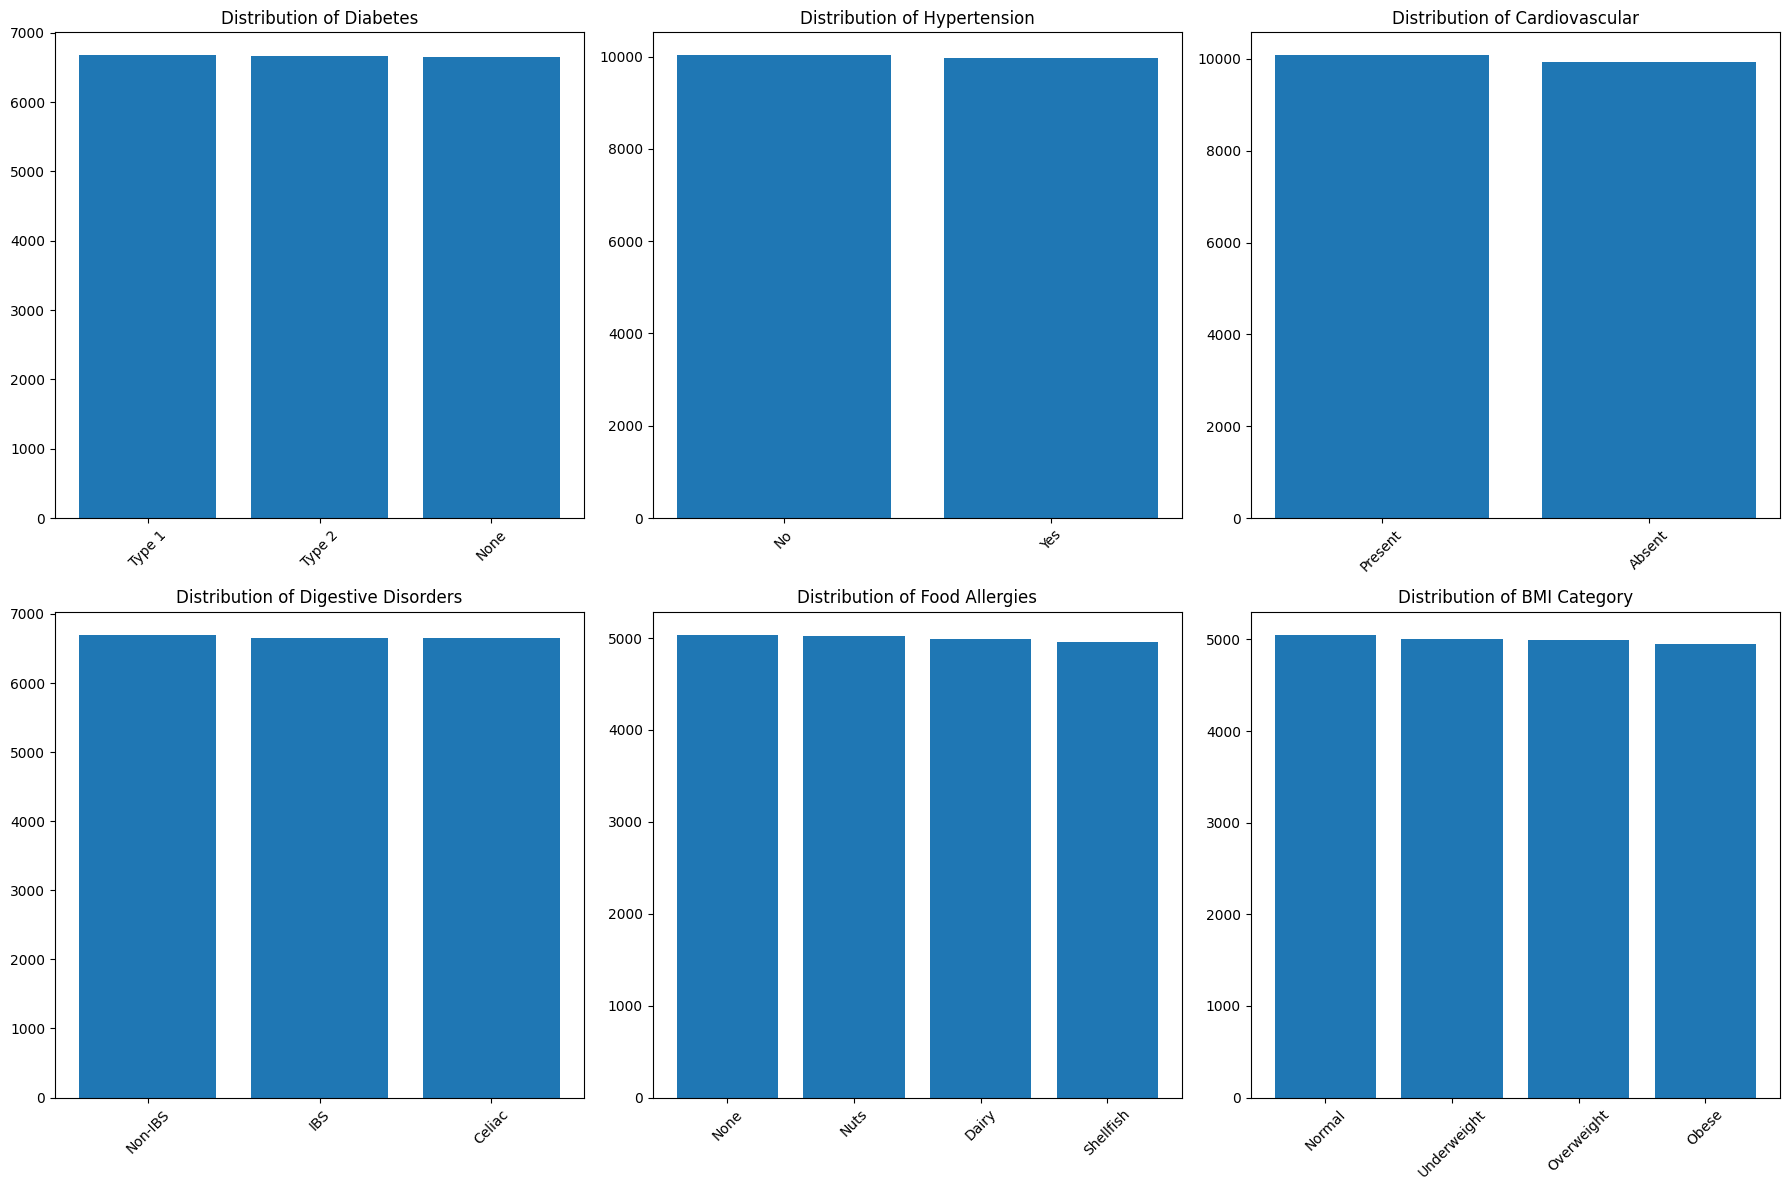


Recipe dataset overview:
                                       name  calories  protein  carbs  fat  \
0  Greek Yogurt with Berries and Chia Seeds       240       18     25    6   
1            Avocado Toast with Poached Egg       320       14     28   15   
2             Spinach and Mushroom Omelette       280       20      5   16   
3         Overnight Oats with Almond Butter       310       12     45   10   
4                   Breakfast Smoothie Bowl       270       15     35    8   

   sodium  meal_type  
0      70  breakfast  
1     380  breakfast  
2     320  breakfast  
3      50  breakfast  
4      60  breakfast  

Health attributes in recipes:
diabetes_friendly: 96 recipes
heart_healthy: 93 recipes
low_sodium: 47 recipes
gluten_free: 82 recipes
vegetarian: 64 recipes
vegan: 33 recipes


In [2]:
# Check for missing values
print("Missing values in training dataset:")
print(train_user_params_df.isnull().sum().sum())
print("\nMissing values in testing dataset:")
print(test_user_params_df.isnull().sum().sum())
print("\nMissing values in recipes dataset:")
print(recipes_df.isnull().sum().sum())

# Fill health-related missing values with "None"
health_cols = ['Diabetes', 'Digestive Disorders', 'Food Allergies', 'Food Intolerances']
for col in health_cols:
    train_user_params_df[col] = train_user_params_df[col].fillna('None')
    test_user_params_df[col] = test_user_params_df[col].fillna('None')

# Fill remaining categorical nulls
train_user_params_df['Exercise Type'] = train_user_params_df['Exercise Type'].fillna('Unknown')
train_user_params_df['Alcohol Consumption'] = train_user_params_df['Alcohol Consumption'].fillna('None')
train_user_params_df['Hypertension'] = train_user_params_df['Hypertension'].fillna('No')
train_user_params_df['Cardiovascular'] = train_user_params_df['Cardiovascular'].fillna('Absent')

test_user_params_df['Exercise Type'] = test_user_params_df['Exercise Type'].fillna('Unknown')
test_user_params_df['Alcohol Consumption'] = test_user_params_df['Alcohol Consumption'].fillna('None')
test_user_params_df['Hypertension'] = test_user_params_df['Hypertension'].fillna('No')
test_user_params_df['Cardiovascular'] = test_user_params_df['Cardiovascular'].fillna('Absent')

# Verify no missing values remain
print("\nRemaining missing values in training dataset:")
print(train_user_params_df.isnull().sum().sum())
print("\nRemaining missing values in testing dataset:")
print(test_user_params_df.isnull().sum().sum())

# Explore distribution of priority health parameters
plt.figure(figsize=(18, 12))

# Plot distributions of health conditions
for i, col in enumerate(['Diabetes', 'Hypertension', 'Cardiovascular', 'Digestive Disorders', 'Food Allergies']):
    plt.subplot(2, 3, i+1)
    value_counts = train_user_params_df[col].value_counts()
    plt.bar(value_counts.index, value_counts.values)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.subplot(2, 3, 6)
value_counts = train_user_params_df['BMI Category'].value_counts()
plt.bar(value_counts.index, value_counts.values)
plt.title('Distribution of BMI Category')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('health_parameter_distributions.png')
plt.show()

# Explore recipes dataset
print("\nRecipe dataset overview:")
print(recipes_df[['name', 'calories', 'protein', 'carbs', 'fat', 'sodium', 'meal_type']].head())

# Check recipe health attributes
health_attrs = ['diabetes_friendly', 'heart_healthy', 'low_sodium', 'gluten_free', 'vegetarian', 'vegan']
if all(attr in recipes_df.columns for attr in health_attrs):
    print("\nHealth attributes in recipes:")
    for attr in health_attrs:
        if attr in recipes_df.columns:
            print(f"{attr}: {recipes_df[attr].sum()} recipes")


In [3]:
# Define priority parameters
high_priority_cols = [
    'Diabetes',           # Highest priority - health condition
    'Hypertension',       # Highest priority - health condition
    'Cardiovascular',     # Highest priority - health condition
    'Digestive Disorders',# Highest priority - health condition
    'Food Allergies',     # Highest priority - health condition
]

medium_priority_cols = [
    'BMI Category',       # Second priority
    'Weight (kg)', 
    'Target Weight (kg)'
]

low_priority_cols = [
    'Meal Size Preference',# Third priority
    'Diet Type',
    'Food Intolerances'
]

# Define categorical and numerical columns
categorical_cols = [
    'Diabetes', 'Hypertension', 'Cardiovascular', 'Digestive Disorders', 
    'Food Allergies', 'BMI Category', 'Meal Size Preference', 
    'Diet Type', 'Food Intolerances', 'Exercise Type', 'Physical Job Activity Level',
    'Work Schedule', 'Sleep Quality', 'Stress Level', 'Meal Timing Regularity',
    'Cooking Skills', 'Food Budget', 'Alcohol Consumption', 'Smoking Status',
    'Snacking Behavior', 'Travel Frequency', 'Cuisine Preferences',
    'Food Texture Preferences', 'Portion Control Ability', 'Previous Diet Success History',
    'Meal Complexity Preference', 'Seasonal Diet Preference', 'Weight Change History',
    'Spice Tolerance'
]

numerical_cols = [
    'Height (cm)', 'Weight (kg)', 'Target Weight (kg)', 'Exercise Frequency', 
    'Exercise Duration (min)', 'Daily Steps Count', 'Sleep Duration (hrs)',
    'Available Cooking Time (min)', 'Water Intake (cups)', 'Eating Out Frequency',
    'Food Prep Time Availability (min)'
]

# Custom transformer for priority weighting
class HealthPriorityTransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer that applies priority weighting to features based on their
    importance for diet planning. Health conditions receive highest weight as they
    directly impact food safety and medical outcomes.
    """
    def __init__(self, high_cols, medium_cols, low_cols, 
                 high_weight=3.0, medium_weight=2.0, low_weight=1.5):
        self.high_cols = high_cols
        self.medium_cols = medium_cols
        self.low_cols = low_cols
        self.high_weight = high_weight
        self.medium_weight = medium_weight
        self.low_weight = low_weight
        self.feature_names_ = None
        
    def fit(self, X, y=None):
        # Store feature names from the preprocessor
        if hasattr(X, 'columns'):
            self.feature_names_ = X.columns
        else:
            # Get feature names from the preprocessor if available
            try:
                self.feature_names_ = self.get_feature_names_out()
            except:
                self.feature_names_ = None
        return self
    
    def transform(self, X):
        """Apply weights to features based on their category"""
        X_weighted = X.copy()
        
        # If X is a numpy array (which it will be after ColumnTransformer)
        if not hasattr(X, 'columns'):
            # Get feature names from the previous step if available
            if hasattr(self, 'feature_names_') and self.feature_names_ is not None:
                # Apply weights based on feature names
                for i, feature_name in enumerate(self.feature_names_):
                    # Apply highest weight to health condition features
                    if any(high_col in feature_name for high_col in self.high_cols):
                        X_weighted[:, i] *= self.high_weight
                    # Apply medium weight to nutritional requirement features
                    elif any(medium_col in feature_name for medium_col in self.medium_cols):
                        X_weighted[:, i] *= self.medium_weight
                    # Apply lower weight to preference features
                    elif any(low_col in feature_name for low_col in self.low_cols):
                        X_weighted[:, i] *= self.low_weight
            return X_weighted
        
        # If X is a DataFrame
        for col in X_weighted.columns:
            # Apply highest weight to health condition features
            if any(high_col in col for high_col in self.high_cols):
                X_weighted[col] *= self.high_weight
            # Apply medium weight to nutritional requirement features
            elif any(medium_col in col for medium_col in self.medium_cols):
                X_weighted[col] *= self.medium_weight
            # Apply lower weight to preference features
            elif any(low_col in col for low_col in self.low_cols):
                X_weighted[col] *= self.low_weight
                
        return X_weighted


# Create preprocessing pipeline
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create the full preprocessing pipeline with priority weighting
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('priority_weighting', HealthPriorityTransformer(
        high_cols=high_priority_cols,
        medium_cols=medium_priority_cols,
        low_cols=low_priority_cols
    ))
])

# Apply preprocessing to training data
X_train_processed = preprocessing_pipeline.fit_transform(train_user_params_df)

print(f"Original data shape: {train_user_params_df.shape}")
print(f"Processed data shape: {X_train_processed.shape}")


Original data shape: (20000, 40)
Processed data shape: (20000, 96)


Original processed features: 96
Reduced features: 60 (preserving 95% variance)


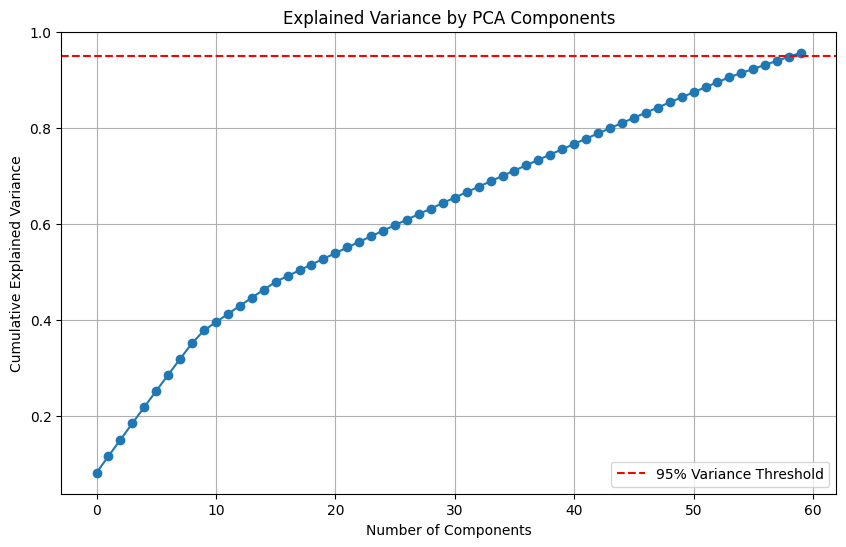

In [4]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Preserve 95% of variance
X_train_reduced = pca.fit_transform(X_train_processed)

print(f"Original processed features: {X_train_processed.shape[1]}")
print(f"Reduced features: {X_train_reduced.shape[1]} (preserving 95% variance)")

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.legend()
plt.grid(True)
plt.savefig('pca_explained_variance.png')
plt.show()


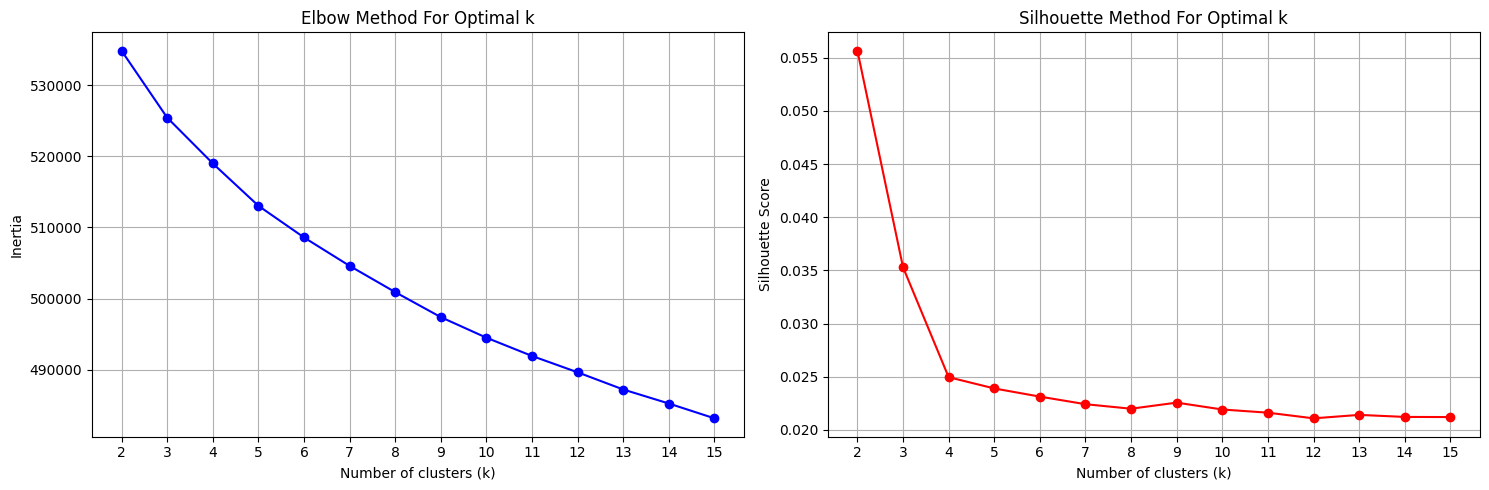

Selected optimal number of clusters: 5
Silhouette score for k=5: 0.0239


In [5]:
# Calculate metrics for different numbers of clusters
k_range = range(2, 16)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_train_reduced)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train_reduced, cluster_labels))

# Plot elbow curve
plt.figure(figsize=(15, 5))

# Elbow method plot
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.xticks(k_range)

# Silhouette score plot
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.grid(True)
plt.xticks(k_range)

plt.tight_layout()
plt.savefig('kmeans_elbow_method.png')
plt.show()

# Find optimal k (based on elbow method and silhouette score)
optimal_k = 5  # Based on visual inspection of the elbow curve

print(f"Selected optimal number of clusters: {optimal_k}")
print(f"Silhouette score for k={optimal_k}: {silhouette_scores[optimal_k-2]:.4f}")


Best K-means parameters: {'init': 'random'}, Silhouette Score: 0.0239

Cluster distribution:
cluster
0    4100
1    4223
2    4210
3    4072
4    3395
Name: count, dtype: int64


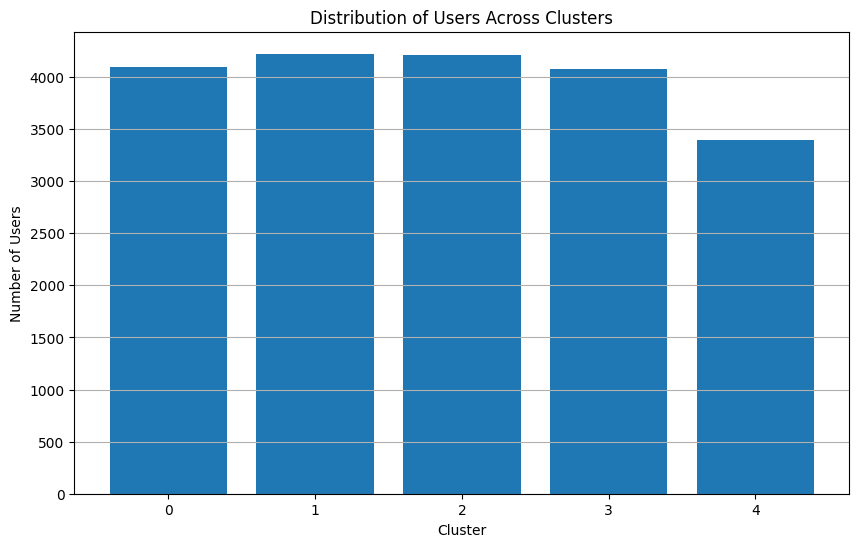

In [7]:
optimal_k = 5
# Try different initialization methods
init_methods = ['k-means++', 'random']
best_score = -1
best_params = {}

for init in init_methods:
    kmeans = KMeans(n_clusters=optimal_k, init=init, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_train_reduced)
    score = silhouette_score(X_train_reduced, clusters)
    
    if score > best_score:
        best_score = score
        best_params = {'init': init}

print(f"Best K-means parameters: {best_params}, Silhouette Score: {best_score:.4f}")

# Use the best parameters
kmeans = KMeans(n_clusters=optimal_k, **best_params, random_state=42, n_init=10)
kmeans.fit(X_train_reduced)

# Assign cluster labels to the training data
train_user_params_df['cluster'] = kmeans.predict(X_train_reduced)

# Check the distribution of clusters
cluster_counts = train_user_params_df['cluster'].value_counts().sort_index()
print("\nCluster distribution:")
print(cluster_counts)

# Visualize cluster distribution
plt.figure(figsize=(10, 6))
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Number of Users')
plt.title('Distribution of Users Across Clusters')
plt.xticks(cluster_counts.index)
plt.grid(axis='y')
plt.savefig('cluster_distribution.png')
plt.show()



Cluster characteristics (most common value in each cluster):
        Diabetes Hypertension Cardiovascular Digestive Disorders  \
cluster                                                            
0         Type 1          Yes        Present             Non-IBS   
1           None           No         Absent             Non-IBS   
2         Type 2           No        Present                 IBS   
3         Type 1           No         Absent              Celiac   
4         Type 2          Yes        Present                 IBS   

        Food Allergies BMI Category Meal Size Preference  
cluster                                                   
0                 Nuts   Overweight      Regular 3 meals  
1                 Nuts  Underweight       Small frequent  
2                 None  Underweight       Small frequent  
3                 None   Overweight      Regular 3 meals  
4            Shellfish        Obese     Large infrequent  


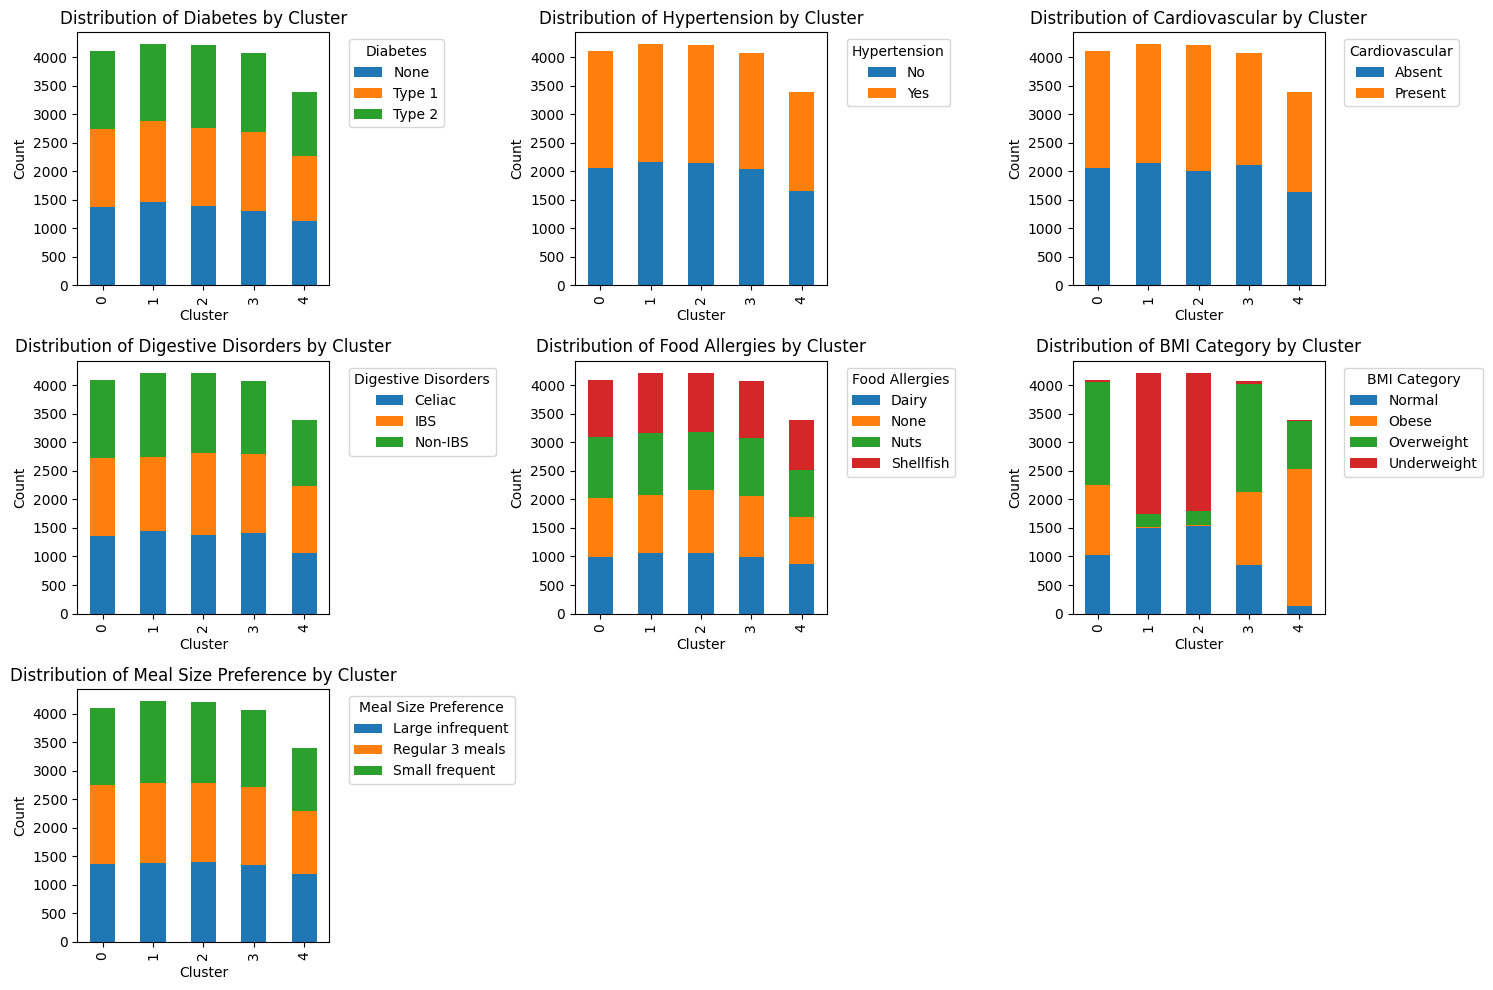

In [8]:
# Analyze the characteristics of each cluster
cluster_analysis = train_user_params_df.groupby('cluster').agg({
    'Diabetes': lambda x: x.value_counts().index[0],
    'Hypertension': lambda x: x.value_counts().index[0],
    'Cardiovascular': lambda x: x.value_counts().index[0],
    'Digestive Disorders': lambda x: x.value_counts().index[0],
    'Food Allergies': lambda x: x.value_counts().index[0],
    'BMI Category': lambda x: x.value_counts().index[0],
    'Meal Size Preference': lambda x: x.value_counts().index[0]
})

print("\nCluster characteristics (most common value in each cluster):")
print(cluster_analysis)

# Visualize cluster characteristics
plt.figure(figsize=(15, 10))
for i, col in enumerate(['Diabetes', 'Hypertension', 'Cardiovascular', 'Digestive Disorders', 'Food Allergies', 'BMI Category', 'Meal Size Preference']):
    plt.subplot(3, 3, i+1)
    
    # Create a cross-tabulation of cluster vs. parameter value
    cross_tab = pd.crosstab(train_user_params_df['cluster'], train_user_params_df[col])
    
    # Plot as a stacked bar chart
    cross_tab.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title(f'Distribution of {col} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

plt.savefig('cluster_characteristics.png')
plt.show()


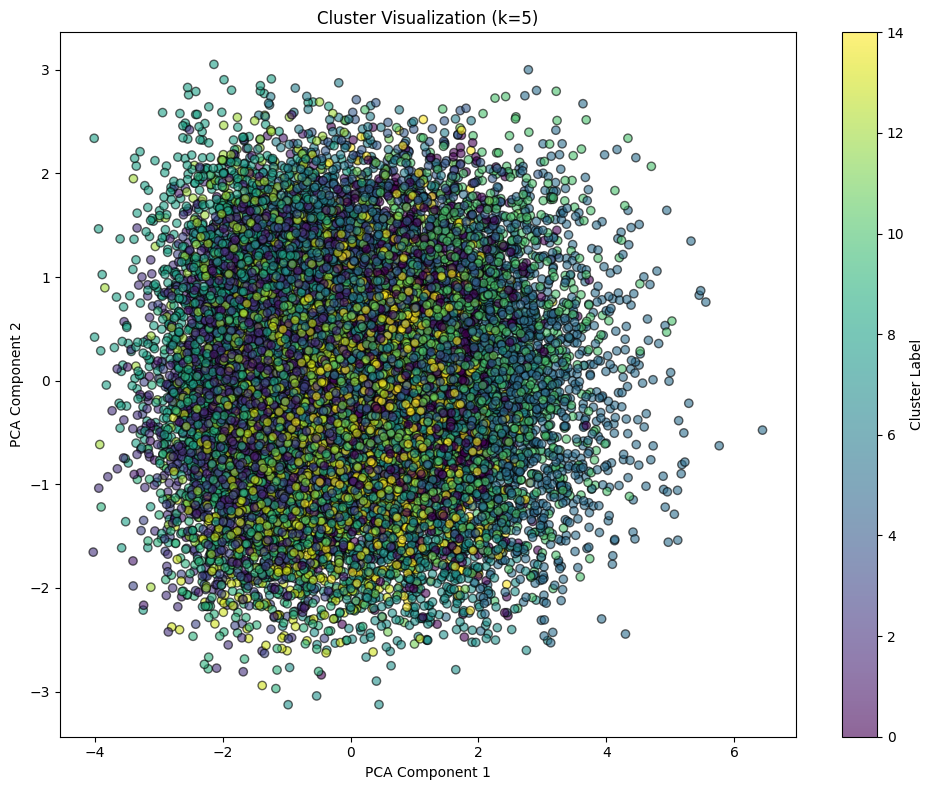

In [10]:
# Perform PCA on reduced data for 2D visualization
pca_2d = PCA(n_components=2)
X_train_2d = pca_2d.fit_transform(X_train_reduced)

# Visualize clusters
plt.figure(figsize=(10, 8))

# Plot the data points, color-coded by their cluster label
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=cluster_labels, cmap='viridis', marker='o', edgecolor='k', alpha=0.6)
plt.title(f'Cluster Visualization (k={optimal_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.tight_layout()
plt.savefig('cluster_visualization_pca.png')
plt.show()


In [11]:
def is_recipe_suitable_for_cluster(cluster_profile, recipe):
    """
    Determines if a recipe is suitable for a user cluster based on health conditions,
    allergies, and dietary preferences.
    """
    # HIGHEST PRIORITY: Check health conditions that affect food safety
    
    # Diabetes check
    if cluster_profile['Diabetes'] in ['Type 1', 'Type 2']:
        if 'diabetes_friendly' in recipe and not recipe['diabetes_friendly']:
            return 0  # Not suitable
    
    # Hypertension check
    if cluster_profile['Hypertension'] == 'Yes':
        if 'low_sodium' in recipe and not recipe['low_sodium']:
            return 0  # Not suitable
    
    # Cardiovascular check
    if cluster_profile['Cardiovascular'] == 'Present':
        if 'heart_healthy' in recipe and not recipe['heart_healthy']:
            return 0  # Not suitable
    
    # Digestive disorders check
    if cluster_profile['Digestive Disorders'] == 'Celiac':
        if 'gluten_free' in recipe and not recipe['gluten_free']:
            return 0  # Not suitable
    
    # Food allergies check - critical for safety
    if 'ingredients' in recipe and isinstance(recipe['ingredients'], str):
        ingredients_lower = recipe['ingredients'].lower()
        
        if cluster_profile['Food Allergies'] == 'Nuts' and any(nut in ingredients_lower for nut in ['nuts', 'peanut', 'almond', 'cashew', 'walnut']):
            return 0  # Not suitable - contains allergen
            
        if cluster_profile['Food Allergies'] == 'Dairy' and any(dairy in ingredients_lower for dairy in ['milk', 'cheese', 'yogurt', 'cream', 'butter']):
            return 0  # Not suitable - contains allergen
            
        if cluster_profile['Food Allergies'] == 'Shellfish' and any(shellfish in ingredients_lower for shellfish in ['shrimp', 'crab', 'lobster', 'prawn']):
            return 0  # Not suitable - contains allergen
    
    # NEW: Dietary preference check
    if 'ingredients' in recipe and isinstance(recipe['ingredients'], str):
        ingredients_lower = recipe['ingredients'].lower()
        recipe_name_lower = recipe['name'].lower() if 'name' in recipe and isinstance(recipe['name'], str) else ""
        
        # Check for vegetarian preference
        if cluster_profile['Diet Type'] == 'Vegetarian':
            non_veg_ingredients = ['chicken', 'beef', 'pork', 'turkey', 'lamb', 'fish', 'salmon', 'tuna', 
                                  'shrimp', 'meat', 'bacon', 'ham', 'sausage', 'seafood', 'cod', 'tilapia']
            if any(ingredient in ingredients_lower or ingredient in recipe_name_lower for ingredient in non_veg_ingredients):
                return 0  # Not suitable for vegetarians
                
        # Check for vegan preference
        elif cluster_profile['Diet Type'] == 'Vegan':
            non_vegan_ingredients = ['chicken', 'beef', 'pork', 'turkey', 'lamb', 'fish', 'salmon', 'tuna', 
                                    'shrimp', 'meat', 'bacon', 'ham', 'sausage', 'seafood', 'milk', 'cheese',
                                    'yogurt', 'cream', 'butter', 'egg', 'honey', 'dairy']
            if any(ingredient in ingredients_lower or ingredient in recipe_name_lower for ingredient in non_vegan_ingredients):
                return 0  # Not suitable for vegans
                
        # Check for pescatarian preference
        elif cluster_profile['Diet Type'] == 'Pescatarian':
            non_pescatarian_ingredients = ['chicken', 'beef', 'pork', 'turkey', 'lamb', 'meat', 'bacon', 'ham', 'sausage']
            if any(ingredient in ingredients_lower or ingredient in recipe_name_lower for ingredient in non_pescatarian_ingredients):
                return 0  # Not suitable for pescatarians
    
    # If passed all safety checks, recipe is suitable
    return 1


In [13]:
import pickle
import pandas as pd
import os

# First, check where you are and what files are available
print(f"Current working directory: {os.getcwd()}")
print("Files in current directory:", os.listdir('.'))

# Create directories if they don't exist
os.makedirs('models', exist_ok=True)
os.makedirs('data', exist_ok=True)

# If you have the files elsewhere, you need to load them first
# Then save them to the expected locations

# After ensuring files are in place, load them
try:
    with open('models/cluster_analysis.pkl', 'rb') as f:
        cluster_analysis = pickle.load(f)
    print('cluster_analysis loaded successfully')
    
    recipes_df = pd.read_csv('data/recipes_modified.csv')
    print('recipes_df loaded successfully')
    
    # Now you can proceed with your Random Forest training code
except Exception as e:
    print(f"Error loading required files: {e}")


Current working directory: C:\BlueMedix-Project-SDRMH482736-\ML
Files in current directory: ['.ipynb_checkpoints', 'app.py', 'cluster_characteristics.png', 'cluster_distribution.png', 'cluster_visualization_pca.png', 'cluster_visualization_tsne.png', 'data', 'Dataset_Generation', 'Diet_plan_generation_model.ipynb', 'health_parameter_distributions.png', 'kmeans_elbow_method.png', 'models', 'pca_explained_variance.png', 'README.md', 'requirements.txt', 'test_results', '__pycache__']
cluster_analysis loaded successfully
recipes_df loaded successfully


In [15]:
# Check if recipes_df is loaded
try:
    print(f"recipes_df shape: {recipes_df.shape}")
    print(f"recipes_df columns: {recipes_df.columns.tolist()}")
    print("recipes_df is loaded successfully")
except NameError:
    print("recipes_df is not defined. Loading it now...")
    try:
        recipes_df = pd.read_csv('data/recipes_modified.csv')
        print(f"recipes_df loaded successfully with shape: {recipes_df.shape}")
    except Exception as e:
        print(f"Error loading recipes_df: {e}")


recipes_df shape: (100, 20)
recipes_df columns: ['recipe_id', 'name', 'meal_type', 'protein', 'carbs', 'fat', 'calories', 'sodium', 'fiber', 'ingredients', 'instructions', 'vegetarian', 'vegan', 'gluten_free', 'diabetes_friendly', 'heart_healthy', 'low_sodium', 'diet_type', 'cooking_difficulty', 'prep_time']
recipes_df is loaded successfully


In [18]:
# Check the columns in cluster_analysis
print(f"Columns in cluster_analysis: {cluster_analysis.columns.tolist()}")

# If 'Diet Type' is missing, we need to add it
if 'Diet Type' not in cluster_analysis.columns:
    print("'Diet Type' column is missing in cluster_analysis. Adding default values...")
    
    # Add a default 'Diet Type' column to cluster_analysis
    # You can modify this based on your cluster characteristics
    cluster_analysis['Diet Type'] = 'Non-spicy'  # Default value
    
    # Optionally, you can assign different diet types to different clusters
    # based on their characteristics
    # For example:
    # cluster_analysis.loc[0, 'Diet Type'] = 'Vegetarian'
    # cluster_analysis.loc[2, 'Diet Type'] = 'Pescatarian'
    
    print("Added 'Diet Type' column to cluster_analysis")


Columns in cluster_analysis: ['Diabetes', 'Hypertension', 'Cardiovascular', 'Digestive Disorders', 'Food Allergies', 'BMI Category', 'Meal Size Preference', 'Diet Type']


In [20]:
# Test the function with a sample
print("Testing is_recipe_suitable_for_cluster function...")
test_result = is_recipe_suitable_for_cluster(cluster_analysis.iloc[0], recipes_df.iloc[0])
print(f"Function test result: {test_result}")


Testing is_recipe_suitable_for_cluster function...
Function test result: 1


In [23]:
import numpy as np
# Step 3: Create enhanced training data
X_train_rf = []
y_train_rf = []

print("Creating enhanced training data for recipe suitability classification...")

# Ensure Diet Type exists in cluster_analysis
if 'Diet Type' not in cluster_analysis.columns:
    print("Adding Diet Type column to cluster_analysis...")
    cluster_analysis['Diet Type'] = 'Non-spicy'  # Default value

for cluster_id, cluster_profile in cluster_analysis.iterrows():
    for _, recipe in recipes_df.iterrows():
        # Extract recipe nutritional features
        recipe_features = recipe[['calories', 'protein', 'carbs', 'fat', 'sodium', 'fiber']].values
        
        # Add cluster ID as a feature
        features = np.append(recipe_features, cluster_id)
        
        # Add recipe type features if available
        if 'meal_type' in recipe:
            # One-hot encode meal type
            is_breakfast = 1 if recipe['meal_type'] == 'breakfast' else 0
            is_lunch = 1 if recipe['meal_type'] == 'lunch' else 0
            is_dinner = 1 if recipe['meal_type'] == 'dinner' else 0
            features = np.append(features, [is_breakfast, is_lunch, is_dinner])
        
        # Determine if recipe is suitable for this cluster
        suitability = is_recipe_suitable_for_cluster(cluster_profile, recipe)
        
        X_train_rf.append(features)
        y_train_rf.append(suitability)

# Convert to numpy arrays
X_train_rf = np.array(X_train_rf)
y_train_rf = np.array(y_train_rf)

# Update feature names to include new features
feature_names = ['calories', 'protein', 'carbs', 'fat', 'sodium', 'fiber', 'cluster_id']
if X_train_rf.shape[1] > 7:  # If we added meal type features
    feature_names.extend(['is_breakfast', 'is_lunch', 'is_dinner'])

# Check class balance
suitable_count = np.sum(y_train_rf == 1)
unsuitable_count = np.sum(y_train_rf == 0)
total_count = len(y_train_rf)

print(f"Enhanced training data created: {total_count} samples")
print(f"Class distribution: {suitable_count} suitable ({suitable_count/total_count:.1%}), "
      f"{unsuitable_count} unsuitable ({unsuitable_count/total_count:.1%})")


Creating enhanced training data for recipe suitability classification...
Enhanced training data created: 500 samples
Class distribution: 324 suitable (64.8%), 176 unsuitable (35.2%)


In [30]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest (reduced for efficiency)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', None],
    'class_weight': [None, 'balanced'],
    'bootstrap': [True]
}

print("Optimizing Random Forest classifier with randomized search...")
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=5,  # Reduced for efficiency
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=0,
    random_state=42
)

random_search.fit(X_train_rf, y_train_rf)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best F1 score: {random_search.best_score_:.4f}")

# Get the best model
rf_model = random_search.best_estimator_

# Fine-tune around the best parameters
fine_tune_params = {}
for param, value in random_search.best_params_.items():
    if param == 'n_estimators':
        fine_tune_params[param] = [max(100, value - 50), value, min(500, value + 50)]
    elif param == 'max_depth' and value is not None:
        fine_tune_params[param] = [max(5, value - 5), value, None]
    elif param == 'min_samples_split':
        fine_tune_params[param] = [max(2, value - 2), value, min(15, value + 2)]
    elif param == 'min_samples_leaf':
        fine_tune_params[param] = [max(1, value - 1), value, min(6, value + 1)]
    else:
        fine_tune_params[param] = [value]

print("Fine-tuning Random Forest with grid search around best parameters...")
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=fine_tune_params,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train_rf, y_train_rf)

print(f"Fine-tuned best parameters: {grid_search.best_params_}")
print(f"Fine-tuned best F1 score: {grid_search.best_score_:.4f}")

# Get the final best model
rf_model = grid_search.best_estimator_


Optimizing Random Forest classifier with randomized search...
Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': None, 'bootstrap': True}
Best F1 score: 0.6194
Fine-tuning Random Forest with grid search around best parameters...
Fine-tuned best parameters: {'bootstrap': True, 'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Fine-tuned best F1 score: 0.6222


Optimizing Random Forest classifier with randomized search...
Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': None, 'bootstrap': True}
Best F1 score: 0.6194
Fine-tuning Random Forest with grid search around best parameters...
Fine-tuned best parameters: {'bootstrap': True, 'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Fine-tuned best F1 score: 0.6222

Final Model Evaluation on Test Set:
Accuracy: 0.8700
Precision: 0.8421
Recall: 0.9846
F1 Score: 0.9078

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.66      0.78        35
           1       0.84      0.98      0.91        65

    accuracy                           0.87       100
   macro avg       0.90      0.82      0.84       100
weighted avg       0.88      0.87      0.86       100


Confusi

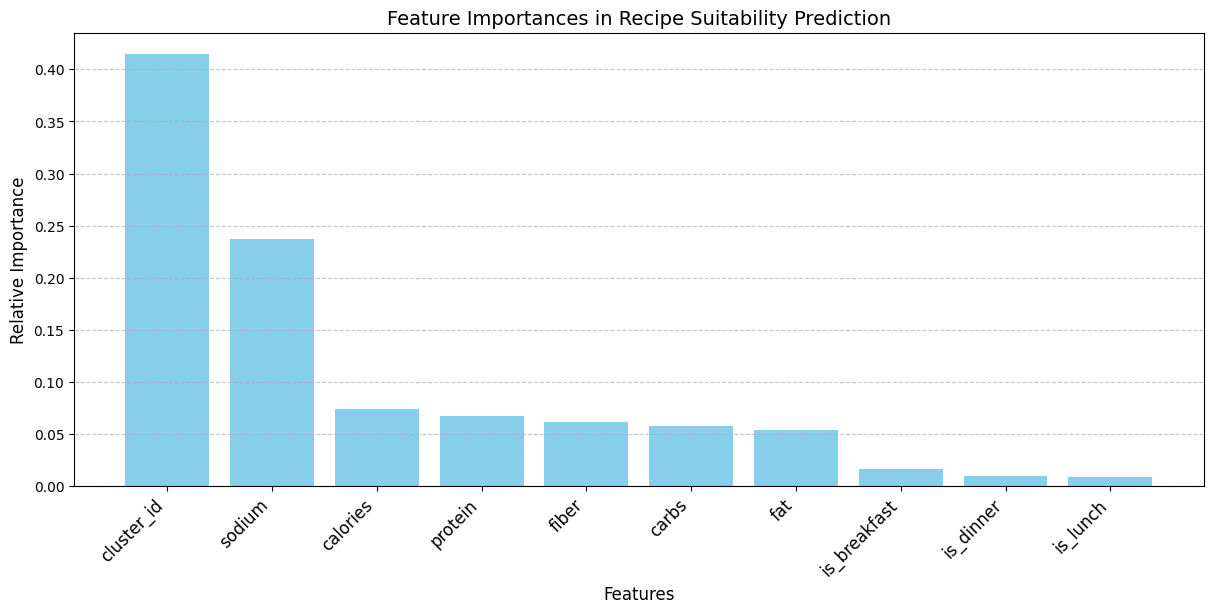

In [31]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, make_scorer
import matplotlib.pyplot as plt
import numpy as np

# Define parameter grid for Random Forest (reduced for efficiency)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', None],
    'class_weight': [None, 'balanced'],
    'bootstrap': [True]
}

print("Optimizing Random Forest classifier with randomized search...")
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=5,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=0,
    random_state=42
)

random_search.fit(X_train_rf, y_train_rf)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best F1 score: {random_search.best_score_:.4f}")

# Get the best model
rf_model = random_search.best_estimator_

# Fine-tune around the best parameters
fine_tune_params = {}
for param, value in random_search.best_params_.items():
    if param == 'n_estimators':
        fine_tune_params[param] = [max(100, value - 50), value, min(500, value + 50)]
    elif param == 'max_depth' and value is not None:
        fine_tune_params[param] = [max(5, value - 5), value, None]
    elif param == 'min_samples_split':
        fine_tune_params[param] = [max(2, value - 2), value, min(15, value + 2)]
    elif param == 'min_samples_leaf':
        fine_tune_params[param] = [max(1, value - 1), value, min(6, value + 1)]
    else:
        fine_tune_params[param] = [value]

print("Fine-tuning Random Forest with grid search around best parameters...")
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=fine_tune_params,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train_rf, y_train_rf)

print(f"Fine-tuned best parameters: {grid_search.best_params_}")
print(f"Fine-tuned best F1 score: {grid_search.best_score_:.4f}")

# Get the final best model
rf_model = grid_search.best_estimator_

# Create a proper train-test split for final evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X_train_rf, y_train_rf, test_size=0.2, random_state=42, stratify=y_train_rf
)

# Train the final model on the training set
final_model = RandomForestClassifier(**grid_search.best_params_, random_state=42)
final_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = final_model.predict(X_test)

# Evaluate the final model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nFinal Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Cross-validation for robustness
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

cv_results = cross_validate(final_model, X_train_rf, y_train_rf, cv=5, scoring=scoring)

print("\nCross-Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"Precision: {cv_results['test_precision'].mean():.4f} ± {cv_results['test_precision'].std():.4f}")
print(f"Recall: {cv_results['test_recall'].mean():.4f} ± {cv_results['test_recall'].std():.4f}")
print(f"F1 Score: {cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}")

# Get feature importances
feature_importances = final_model.feature_importances_

# Define feature names explicitly based on your data
feature_names = ['calories', 'protein', 'carbs', 'fat', 'sodium', 'fiber', 'cluster_id']
if X_train.shape[1] > 7:  # If meal type features were added
    feature_names.extend(['is_breakfast', 'is_lunch', 'is_dinner'])

# Sort features by importance
indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importances = feature_importances[indices]

# Plot top features (all of them if less than 10)
num_features = min(10, len(feature_names))
plt.figure(figsize=(12, 6))
plt.title("Feature Importances in Recipe Suitability Prediction", fontsize=14)
plt.bar(range(num_features), sorted_importances[:num_features], align="center", color='skyblue')
plt.xticks(range(num_features), sorted_feature_names[:num_features], rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.ylabel("Relative Importance", fontsize=12)
plt.xlabel("Features", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()




In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime

def generate_diet_plan(user_params, kmeans_model, pca, rf_model, recipes_df, cluster_analysis, categorical_cols, days=7):
    """Generate a 7-day diet plan for a user based on their parameters"""
    # Create a DataFrame with the user parameters
    user_df = pd.DataFrame([user_params])
    
    # Fill NaN values in object columns with 'Unknown'
    for col in user_df.select_dtypes(include=['object']).columns:
        user_df[col] = user_df[col].fillna('Unknown')
    
    # Ensure all categorical columns are string type
    for col in user_df.select_dtypes(include=['object']).columns:
        user_df[col] = user_df[col].astype(str)
    
    # Ensure all expected columns exist in the user data
    for col in categorical_cols:
        if col not in user_df.columns:
            user_df[col] = 'Unknown'  # Add missing columns with default values
    
    # Preprocess user parameters
    user_features = preprocessing_pipeline.transform(user_df)
    
    # Apply PCA reduction
    user_reduced = pca.transform(user_features)
    
    # Assign user to a cluster
    user_cluster = kmeans_model.predict(user_reduced)[0]
    cluster_profile = cluster_analysis.loc[user_cluster]
    
    # Find suitable recipes for this user's cluster
    suitable_recipes = []
    
    # Get user's diet type preference
    diet_type = user_params['Diet Type']
    
    for _, recipe in recipes_df.iterrows():
        # Create features for prediction
        recipe_features = recipe[['calories', 'protein', 'carbs', 'fat', 'sodium', 'fiber']].values
        features_with_cluster = np.append(recipe_features, user_cluster)
        
        # Add meal type features
        if 'meal_type' in recipe:
            is_breakfast = 1 if recipe['meal_type'] == 'breakfast' else 0
            is_lunch = 1 if recipe['meal_type'] == 'lunch' else 0
            is_dinner = 1 if recipe['meal_type'] == 'dinner' else 0
            features_with_cluster = np.append(features_with_cluster, [is_breakfast, is_lunch, is_dinner])
        
        # Predict suitability using Random Forest
        suitability = rf_model.predict([features_with_cluster])[0]

        
        # Check if recipe matches dietary preferences
        diet_suitable = True
        
        # Filter based on diet type
        recipe_name = recipe['name'].lower() if 'name' in recipe and isinstance(recipe['name'], str) else ""
        recipe_ingredients = recipe['ingredients'].lower() if 'ingredients' in recipe and isinstance(recipe['ingredients'], str) else ""
        
        # Check for vegetarian preference
        if diet_type == 'Vegetarian':
            non_veg_ingredients = ['chicken', 'beef', 'pork', 'turkey', 'lamb', 'fish', 'salmon', 'tuna', 
                                  'shrimp', 'meat', 'bacon', 'ham', 'sausage', 'seafood', 'cod', 'tilapia']
            if any(ingredient in recipe_name or ingredient in recipe_ingredients for ingredient in non_veg_ingredients):
                diet_suitable = False
                
        # Check for vegan preference
        elif diet_type == 'Vegan':
            non_vegan_ingredients = ['chicken', 'beef', 'pork', 'turkey', 'lamb', 'fish', 'salmon', 'tuna', 
                                    'shrimp', 'meat', 'bacon', 'ham', 'sausage', 'seafood', 'milk', 'cheese',
                                    'yogurt', 'cream', 'butter', 'egg', 'honey', 'dairy']
            if any(ingredient in recipe_name or ingredient in recipe_ingredients for ingredient in non_vegan_ingredients):
                diet_suitable = False
                
        # Check for pescatarian preference
        elif diet_type == 'Pescatarian':
            non_pescatarian_ingredients = ['chicken', 'beef', 'pork', 'turkey', 'lamb', 'meat', 'bacon', 'ham', 'sausage']
            if any(ingredient in recipe_name or ingredient in recipe_ingredients for ingredient in non_pescatarian_ingredients):
                diet_suitable = False
        
        # Add recipe if it's suitable based on both RF model and dietary preferences
        if suitability == 1 and diet_suitable:
            suitable_recipes.append(recipe)
    
    print(f"Found {len(suitable_recipes)} suitable recipes for this user with diet type: {diet_type}")
    
    # Create meal plan based on meal size preference
    meal_plan = {}
    meal_preference = user_params['Meal Size Preference']
    
    if meal_preference == 'Small frequent':
        meals_per_day = 5
        meal_types = ['Breakfast', 'Morning Snack', 'Lunch', 'Afternoon Snack', 'Dinner']
    elif meal_preference == 'Regular 3 meals':
        meals_per_day = 3
        meal_types = ['Breakfast', 'Lunch', 'Dinner']
    else:  # Large infrequent
        meals_per_day = 2
        meal_types = ['Brunch', 'Dinner']
    
    # Set calorie targets based on BMI category
    bmi_category = user_params['BMI Category']
    if bmi_category == 'Underweight':
        daily_calorie_target = 2500  # Higher calories for weight gain
    elif bmi_category == 'Normal':
        daily_calorie_target = 2000  # Maintenance calories
    elif bmi_category == 'Overweight':
        daily_calorie_target = 1800  # Moderate deficit
    else:  # Obese
        daily_calorie_target = 1500  # Larger deficit
    
    # Track used recipes to ensure variety
    used_recipes = set()
    
    # Generate plan for each day
    for day in range(1, days+1):
        meal_plan[f'Day {day}'] = {}
        day_calories = 0
        
        # Assign recipes to each meal
        for meal_type in meal_types:
            # Filter recipes appropriate for the meal time
            if 'Breakfast' in meal_type or 'Morning' in meal_type or 'Brunch' in meal_type:
                meal_recipes = [r for r in suitable_recipes if 'meal_type' in r and r['meal_type'] == 'breakfast']
            elif 'Lunch' in meal_type or 'Afternoon' in meal_type:
                meal_recipes = [r for r in suitable_recipes if 'meal_type' in r and r['meal_type'] == 'lunch']
            else:  # Dinner
                meal_recipes = [r for r in suitable_recipes if 'meal_type' in r and r['meal_type'] == 'dinner']
            
            # Prioritize recipes not used yet for variety
            unused_recipes = [r for r in meal_recipes if r['name'] not in used_recipes]
            
            # If we've used all recipes, allow reuse
            if not unused_recipes and meal_recipes:
                unused_recipes = meal_recipes
            
            # Select a recipe
            if unused_recipes:
                import random
                selected_recipe = random.choice(unused_recipes)
                
                # Track used recipe and calories
                used_recipes.add(selected_recipe['name'])
                day_calories += selected_recipe['calories']
                
                meal_plan[f'Day {day}'][meal_type] = {
                    'name': selected_recipe['name'],
                    'calories': float(selected_recipe['calories']),
                    'protein': float(selected_recipe['protein']),
                    'carbs': float(selected_recipe['carbs']),
                    'fat': float(selected_recipe['fat']),
                    'sodium': float(selected_recipe['sodium']),
                    'fiber': float(selected_recipe['fiber'])
                }
            else:
                meal_plan[f'Day {day}'][meal_type] = "No suitable recipe found"
    
    # Analyze nutritional content of the meal plan
    nutritional_analysis = analyze_meal_plan(meal_plan, user_params)
    
    return meal_plan, user_cluster, nutritional_analysis

def analyze_meal_plan(meal_plan, user_params):
    """
    Analyzes the nutritional content of a generated meal plan.
    """
    # Calculate daily nutritional totals
    daily_nutrition = []
    
    for day, meals in meal_plan.items():
        day_nutrition = {
            'calories': 0,
            'protein': 0,
            'carbs': 0,
            'fat': 0,
            'sodium': 0,
            'fiber': 0
        }
        
        for meal_type, meal in meals.items():
            if isinstance(meal, dict):  # If a recipe was found
                day_nutrition['calories'] += meal.get('calories', 0)
                day_nutrition['protein'] += meal.get('protein', 0)
                day_nutrition['carbs'] += meal.get('carbs', 0)
                day_nutrition['fat'] += meal.get('fat', 0)
                day_nutrition['sodium'] += meal.get('sodium', 0)
                day_nutrition['fiber'] += meal.get('fiber', 0)
        
        daily_nutrition.append(day_nutrition)
    
    # Calculate averages
    avg_nutrition = {
        'calories': np.mean([day['calories'] for day in daily_nutrition]),
        'protein': np.mean([day['protein'] for day in daily_nutrition]),
        'carbs': np.mean([day['carbs'] for day in daily_nutrition]),
        'fat': np.mean([day['fat'] for day in daily_nutrition]),
        'sodium': np.mean([day['sodium'] for day in daily_nutrition]),
        'fiber': np.mean([day['fiber'] for day in daily_nutrition])
    }
    
    # Calculate macronutrient percentages
    total_calories = avg_nutrition['protein'] * 4 + avg_nutrition['carbs'] * 4 + avg_nutrition['fat'] * 9
    
    if total_calories > 0:
        macro_percentages = {
            'protein_pct': (avg_nutrition['protein'] * 4 / total_calories * 100),
            'carbs_pct': (avg_nutrition['carbs'] * 4 / total_calories * 100),
            'fat_pct': (avg_nutrition['fat'] * 9 / total_calories * 100)
        }
    else:
        macro_percentages = {'protein_pct': 0, 'carbs_pct': 0, 'fat_pct': 0}
    
    # Calculate variety metrics
    all_recipes = []
    for day, meals in meal_plan.items():
        for meal_type, meal in meals.items():
            if isinstance(meal, dict) and 'name' in meal:
                all_recipes.append(meal['name'])
    
    variety_metrics = {
        'unique_recipes': len(set(all_recipes)),
        'total_meals': len(all_recipes),
        'variety_score': len(set(all_recipes)) / len(all_recipes) * 100 if all_recipes else 0
    }
    
    # Calculate meal coverage (percentage of meals with suitable recipes)
    total_meals = sum(1 for day in meal_plan.values() for meal in day.values())
    suitable_meals = sum(1 for day in meal_plan.values() for meal in day.values() if isinstance(meal, dict))
    meal_coverage = (suitable_meals / total_meals * 100) if total_meals > 0 else 0
    
    # Combine all metrics
    analysis = {
        'avg_nutrition': avg_nutrition,
        'macro_percentages': macro_percentages,
        'variety_metrics': variety_metrics,
        'meal_coverage': meal_coverage
    }
    
    return analysis


In [38]:
# Generate a diet plan for a test user
test_user = test_user_params_df.iloc[0]
diet_plan, user_cluster, nutritional_analysis = generate_diet_plan(
    test_user, kmeans, pca, rf_model, recipes_df, cluster_analysis, categorical_cols)

# Display the diet plan for Day 1 as an example
print("\nDay 1 Diet Plan:")
for meal_type, meal in diet_plan['Day 1'].items():
    if isinstance(meal, dict):
        print(f"  {meal_type}: {meal['name']} ({meal['calories']} calories)")
    else:
        print(f"  {meal_type}: {meal}")

# Display nutritional analysis
print("\nNutritional Analysis:")
print(f"Average daily calories: {nutritional_analysis['avg_nutrition']['calories']:.1f}")
print(f"Macronutrient ratio - Protein: {nutritional_analysis['macro_percentages']['protein_pct']:.1f}%, "
      f"Carbs: {nutritional_analysis['macro_percentages']['carbs_pct']:.1f}%, "
      f"Fat: {nutritional_analysis['macro_percentages']['fat_pct']:.1f}%")
print(f"Recipe variety: {nutritional_analysis['variety_metrics']['variety_score']:.1f}%")
print(f"Meal coverage: {nutritional_analysis['meal_coverage']:.1f}%")


Found 36 suitable recipes for this user with diet type: Non-spicy

Day 1 Diet Plan:
  Breakfast: Buckwheat Crepes with Berries (240.0 calories)
  Lunch: Lentil Soup with Vegetables (260.0 calories)
  Dinner: Baked Salmon with Roasted Vegetables (340.0 calories)

Nutritional Analysis:
Average daily calories: 832.9
Macronutrient ratio - Protein: 25.7%, Carbs: 40.5%, Fat: 33.8%
Recipe variety: 100.0%
Meal coverage: 100.0%


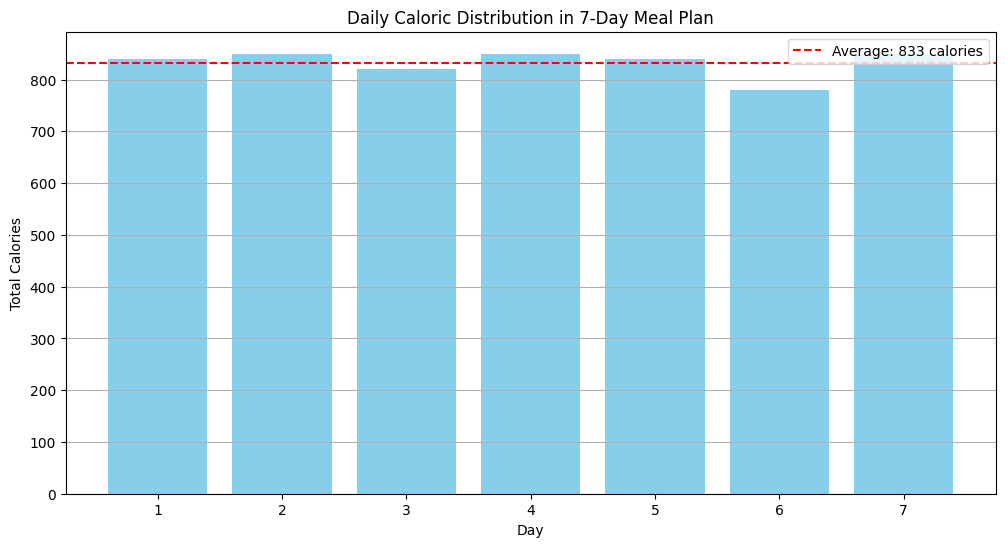

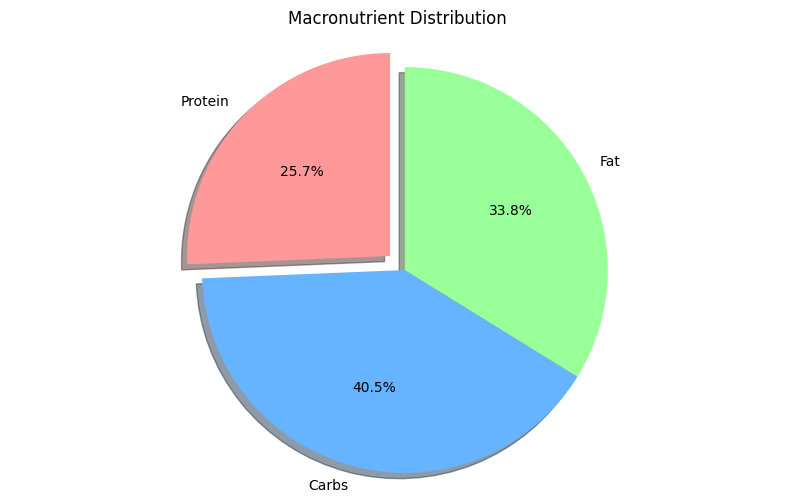

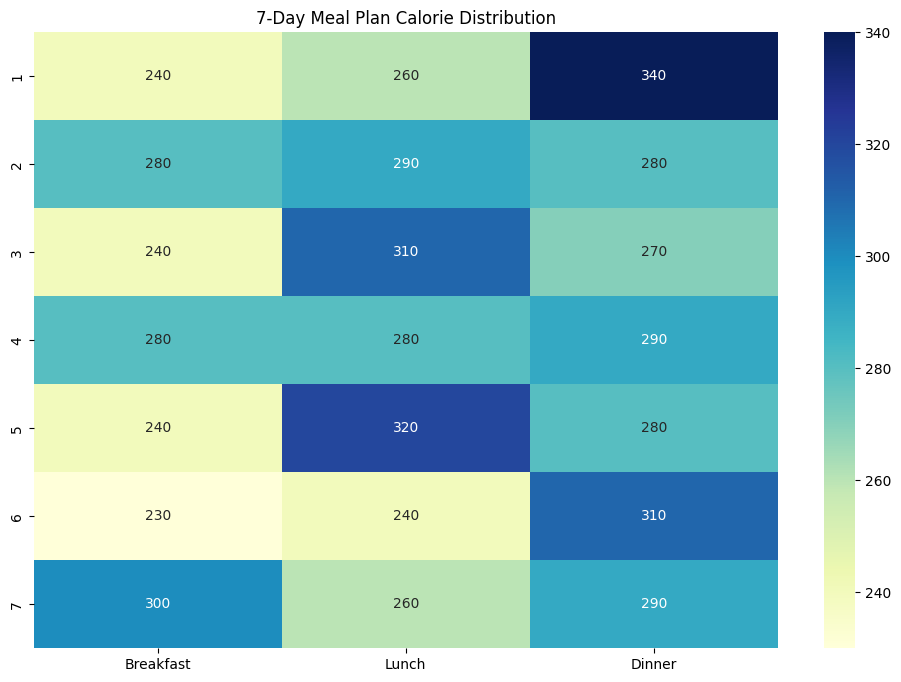

In [39]:
# Visualize daily calorie distribution
plt.figure(figsize=(12, 6))
daily_calories = [sum(meal['calories'] for meal_type, meal in day_meals.items() 
                      if isinstance(meal, dict)) 
                  for day, day_meals in diet_plan.items()]
days = [day.replace('Day ', '') for day in diet_plan.keys()]

plt.bar(days, daily_calories, color='skyblue')
plt.axhline(y=np.mean(daily_calories), color='r', linestyle='--', 
            label=f'Average: {np.mean(daily_calories):.0f} calories')
plt.xlabel('Day')
plt.ylabel('Total Calories')
plt.title('Daily Caloric Distribution in 7-Day Meal Plan')
plt.legend()
plt.grid(axis='y')
plt.savefig('daily_calories.png')
plt.show()

# Visualize macronutrient distribution
plt.figure(figsize=(10, 6))
labels = ['Protein', 'Carbs', 'Fat']
sizes = [
    nutritional_analysis['macro_percentages']['protein_pct'],
    nutritional_analysis['macro_percentages']['carbs_pct'],
    nutritional_analysis['macro_percentages']['fat_pct']
]
colors = ['#ff9999','#66b3ff','#99ff99']
explode = (0.1, 0, 0)  # explode the 1st slice (Protein)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Macronutrient Distribution')
plt.savefig('macronutrient_distribution.png')
plt.show()

# Create a heatmap of meal calories throughout the week
meal_calories = {}
for day, meals in diet_plan.items():
    for meal_type, meal in meals.items():
        if isinstance(meal, dict):
            if meal_type not in meal_calories:
                meal_calories[meal_type] = []
            meal_calories[meal_type].append(meal['calories'])
        else:
            if meal_type not in meal_calories:
                meal_calories[meal_type] = []
            meal_calories[meal_type].append(0)

# Convert to DataFrame for heatmap
meal_df = pd.DataFrame(meal_calories, index=days)

plt.figure(figsize=(12, 8))
sns.heatmap(meal_df, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('7-Day Meal Plan Calorie Distribution')
plt.savefig('meal_plan_heatmap.png')
plt.show()



Generating diet plan for test user 1
Found 36 suitable recipes for this user with diet type: Non-spicy
User 1 (Cluster 0):
  BMI Category: Overweight
  Meal Preference: Regular 3 meals
  Average daily calories: 854.3
  Meal coverage: 100.0%

Generating diet plan for test user 2
Found 42 suitable recipes for this user with diet type: Pescatarian
User 2 (Cluster 1):
  BMI Category: Underweight
  Meal Preference: Regular 3 meals
  Average daily calories: 850.0
  Meal coverage: 100.0%

Generating diet plan for test user 3
Found 37 suitable recipes for this user with diet type: Vegetarian
User 3 (Cluster 1):
  BMI Category: Underweight
  Meal Preference: Large infrequent
  Average daily calories: 557.1
  Meal coverage: 100.0%

Generating diet plan for test user 4
Found 21 suitable recipes for this user with diet type: Vegan
User 4 (Cluster 3):
  BMI Category: Overweight
  Meal Preference: Large infrequent
  Average daily calories: 525.7
  Meal coverage: 100.0%

Generating diet plan for tes

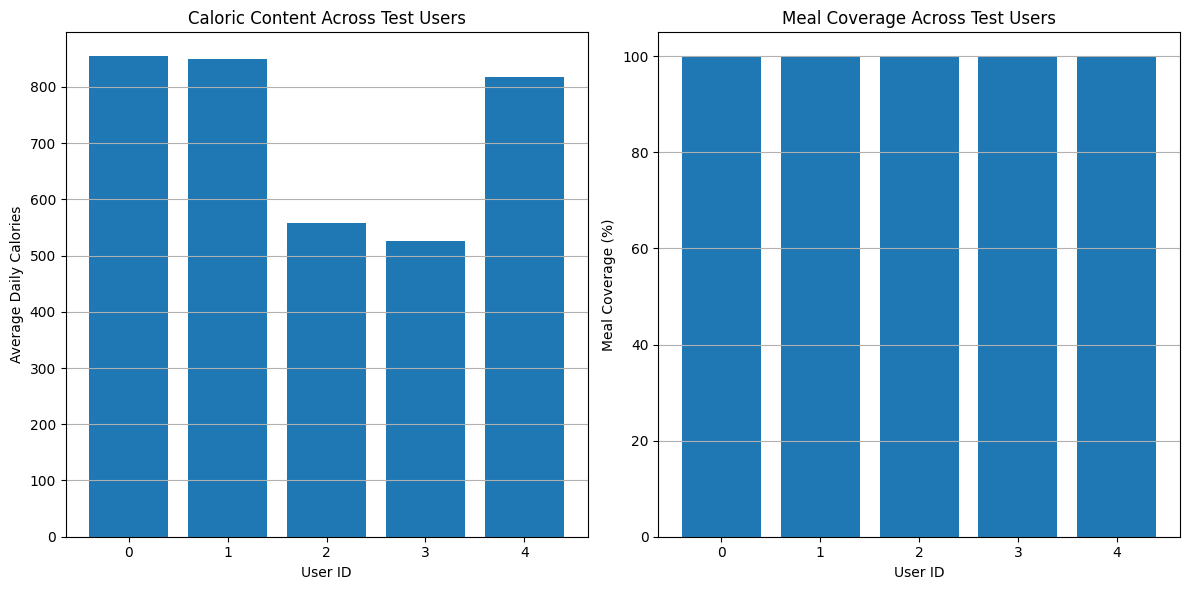

In [41]:
# Generate diet plans for multiple test users
num_test_users = 5  # Adjust as needed
test_results = []

for i in range(min(num_test_users, len(test_user_params_df))):
    test_user = test_user_params_df.iloc[i]
    print(f"\nGenerating diet plan for test user {i+1}")
    
    diet_plan, user_cluster, nutritional_analysis = generate_diet_plan(
        test_user, kmeans, pca, rf_model, recipes_df, cluster_analysis, categorical_cols)
    
    # Store results
    test_results.append({
        'user_id': i,
        'cluster': user_cluster,
        'diet_plan': diet_plan,
        'nutritional_analysis': nutritional_analysis
    })
    
    # Print a brief summary
    print(f"User {i+1} (Cluster {user_cluster}):")
    print(f"  BMI Category: {test_user['BMI Category']}")
    print(f"  Meal Preference: {test_user['Meal Size Preference']}")
    print(f"  Average daily calories: {nutritional_analysis['avg_nutrition']['calories']:.1f}")
    print(f"  Meal coverage: {nutritional_analysis['meal_coverage']:.1f}%")

# Analyze results across users
clusters = [r['cluster'] for r in test_results]
calories = [r['nutritional_analysis']['avg_nutrition']['calories'] for r in test_results]
coverage = [r['nutritional_analysis']['meal_coverage'] for r in test_results]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(len(test_results)), calories)
plt.xlabel('User ID')
plt.ylabel('Average Daily Calories')
plt.title('Caloric Content Across Test Users')
plt.grid(axis='y')

plt.subplot(1, 2, 2)
plt.bar(range(len(test_results)), coverage)
plt.xlabel('User ID')
plt.ylabel('Meal Coverage (%)')
plt.title('Meal Coverage Across Test Users')
plt.grid(axis='y')

plt.tight_layout()
plt.savefig('test_users_comparison.png')
plt.show()



===== Diet Plan Generation Model Evaluation =====
Number of test users evaluated: 5

Nutritional Metrics:
Average daily calories: 720.9
Average macronutrient distribution - Protein: 25.1%, Carbs: 42.7%, Fat: 32.2%
Average recipe variety score: 87.1%
Average meal coverage: 100.0%

Cluster Distribution:
Cluster 0: 2 users (40.0%)
Cluster 1: 2 users (40.0%)
Cluster 3: 1 users (20.0%)


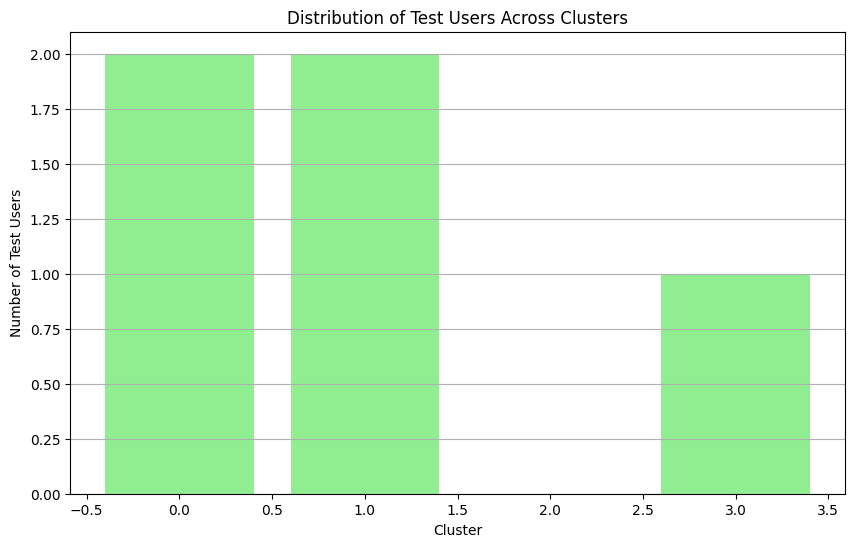

In [42]:
def evaluate_model_performance(test_results):
    """
    Evaluates the overall performance of the diet plan generation model.
    """
    # Calculate average metrics across all test users
    avg_calories = np.mean([r['nutritional_analysis']['avg_nutrition']['calories'] for r in test_results])
    avg_protein_pct = np.mean([r['nutritional_analysis']['macro_percentages']['protein_pct'] for r in test_results])
    avg_carbs_pct = np.mean([r['nutritional_analysis']['macro_percentages']['carbs_pct'] for r in test_results])
    avg_fat_pct = np.mean([r['nutritional_analysis']['macro_percentages']['fat_pct'] for r in test_results])
    avg_variety = np.mean([r['nutritional_analysis']['variety_metrics']['variety_score'] for r in test_results])
    avg_coverage = np.mean([r['nutritional_analysis']['meal_coverage'] for r in test_results])
    
    # Print summary
    print("\n===== Diet Plan Generation Model Evaluation =====")
    print(f"Number of test users evaluated: {len(test_results)}")
    print("\nNutritional Metrics:")
    print(f"Average daily calories: {avg_calories:.1f}")
    print(f"Average macronutrient distribution - Protein: {avg_protein_pct:.1f}%, "
          f"Carbs: {avg_carbs_pct:.1f}%, Fat: {avg_fat_pct:.1f}%")
    print(f"Average recipe variety score: {avg_variety:.1f}%")
    print(f"Average meal coverage: {avg_coverage:.1f}%")
    
    # Calculate cluster distribution
    cluster_counts = {}
    for r in test_results:
        cluster = r['cluster']
        if cluster not in cluster_counts:
            cluster_counts[cluster] = 0
        cluster_counts[cluster] += 1
    
    print("\nCluster Distribution:")
    for cluster, count in cluster_counts.items():
        print(f"Cluster {cluster}: {count} users ({count/len(test_results)*100:.1f}%)")
    
    return {
        'avg_calories': avg_calories,
        'avg_protein_pct': avg_protein_pct,
        'avg_carbs_pct': avg_carbs_pct,
        'avg_fat_pct': avg_fat_pct,
        'avg_variety': avg_variety,
        'avg_coverage': avg_coverage,
        'cluster_distribution': cluster_counts
    }

# Evaluate model performance
performance_metrics = evaluate_model_performance(test_results)

# Visualize cluster distribution
plt.figure(figsize=(10, 6))
clusters = list(performance_metrics['cluster_distribution'].keys())
counts = list(performance_metrics['cluster_distribution'].values())
plt.bar(clusters, counts, color='lightgreen')
plt.xlabel('Cluster')
plt.ylabel('Number of Test Users')
plt.title('Distribution of Test Users Across Clusters')
plt.grid(axis='y')
plt.savefig('test_user_clusters.png')
plt.show()


In [43]:
def process_test_data(test_user_params_df, kmeans, pca, rf_model, recipes_df, cluster_analysis, num_users=5):
    """
    Process test users and generate diet plans
    
    Args:
        test_user_params_df: DataFrame containing test user parameters
        kmeans: Trained K-means clustering model
        pca: Fitted PCA model
        rf_model: Trained Random Forest classifier
        recipes_df: DataFrame containing recipes
        cluster_analysis: DataFrame containing cluster profiles
        num_users: Number of test users to process
        
    Returns:
        test_results: List of dictionaries containing diet plans and analysis
    """
    test_results = []
    
    # Process a subset of test users
    for i in range(min(num_users, len(test_user_params_df))):
        test_user = test_user_params_df.iloc[i]
        print(f"\n{'='*50}")
        print(f"Processing test user {i+1}")
        print(f"{'='*50}")
        
        # Display key user parameters
        print(f"Diabetes: {test_user['Diabetes']}")
        print(f"Hypertension: {test_user['Hypertension']}")
        print(f"Cardiovascular: {test_user['Cardiovascular']}")
        print(f"Digestive Disorders: {test_user['Digestive Disorders']}")
        print(f"Food Allergies: {test_user['Food Allergies']}")
        print(f"BMI Category: {test_user['BMI Category']}")
        print(f"Meal Size Preference: {test_user['Meal Size Preference']}")
        
        # Generate diet plan
        try:
            diet_plan, user_cluster, nutritional_analysis = generate_diet_plan(
                test_user, kmeans, pca, rf_model, recipes_df, cluster_analysis)
            
            # Store results
            test_results.append({
                'user_id': i,
                'user_params': test_user,
                'cluster': user_cluster,
                'diet_plan': diet_plan,
                'nutritional_analysis': nutritional_analysis
            })
            
            # Display diet plan summary
            print(f"\nDiet Plan Summary for User {i+1}:")
            print(f"Average daily calories: {nutritional_analysis['avg_nutrition']['calories']:.1f}")
            print(f"Macronutrient ratio - Protein: {nutritional_analysis['macro_percentages']['protein_pct']:.1f}%, "
                  f"Carbs: {nutritional_analysis['macro_percentages']['carbs_pct']:.1f}%, "
                  f"Fat: {nutritional_analysis['macro_percentages']['fat_pct']:.1f}%")
            print(f"Recipe variety: {nutritional_analysis['variety_metrics']['variety_score']:.1f}%")
            print(f"Meal coverage: {nutritional_analysis['meal_coverage']:.1f}%")
            
            # Display first day as example
            print("\nDay 1 Sample:")
            for meal_type, meal in diet_plan['Day 1'].items():
                if isinstance(meal, dict):
                    print(f"  {meal_type}: {meal['name']} ({meal['calories']} calories)")
                else:
                    print(f"  {meal_type}: {meal}")
                    
        except Exception as e:
            print(f"Error processing user {i+1}: {str(e)}")
            import traceback
            traceback.print_exc()
    
    return test_results


In [44]:
# Check if all required objects exist
print("Checking required objects:")
print(f"test_user_params_df: {type(test_user_params_df) if 'test_user_params_df' in globals() else 'Not defined'}")
print(f"kmeans: {type(kmeans) if 'kmeans' in globals() else 'Not defined'}")
print(f"pca: {type(pca) if 'pca' in globals() else 'Not defined'}")
print(f"rf_model: {type(rf_model) if 'rf_model' in globals() else 'Not defined'}")
print(f"recipes_df: {type(recipes_df) if 'recipes_df' in globals() else 'Not defined'}")
print(f"cluster_analysis: {type(cluster_analysis) if 'cluster_analysis' in globals() else 'Not defined'}")


Checking required objects:
test_user_params_df: <class 'pandas.core.frame.DataFrame'>
kmeans: <class 'sklearn.cluster._kmeans.KMeans'>
pca: <class 'sklearn.decomposition._pca.PCA'>
rf_model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
recipes_df: <class 'pandas.core.frame.DataFrame'>
cluster_analysis: <class 'pandas.core.frame.DataFrame'>


In [45]:
def process_test_data(test_user_params_df, kmeans, pca, rf_model, recipes_df, cluster_analysis, num_users=5):
    """
    Process test users and generate diet plans
    
    Args:
        test_user_params_df: DataFrame containing test user parameters
        kmeans: Trained K-means clustering model
        pca: Fitted PCA model
        rf_model: Trained Random Forest classifier
        recipes_df: DataFrame containing recipes
        cluster_analysis: DataFrame containing cluster profiles
        num_users: Number of test users to process
        
    Returns:
        test_results: List of dictionaries containing diet plans and analysis
    """
    print("Starting process_test_data function")
    test_results = []
    
    try:
        # Process a subset of test users
        for i in range(min(num_users, len(test_user_params_df))):
            print(f"\nProcessing test user {i+1}")
            
            try:
                test_user = test_user_params_df.iloc[i]
                
                # Display key user parameters
                print(f"Diabetes: {test_user['Diabetes']}")
                print(f"Hypertension: {test_user['Hypertension']}")
                print(f"Cardiovascular: {test_user['Cardiovascular']}")
                print(f"Digestive Disorders: {test_user['Digestive Disorders']}")
                print(f"Food Allergies: {test_user['Food Allergies']}")
                print(f"BMI Category: {test_user['BMI Category']}")
                print(f"Meal Size Preference: {test_user['Meal Size Preference']}")
                
                # Generate diet plan
                print("Calling generate_diet_plan function")
                diet_plan, user_cluster, nutritional_analysis = generate_diet_plan(
                    test_user, kmeans, pca, rf_model, recipes_df, cluster_analysis)
                
                print("Diet plan generated successfully")
                
                # Store results
                test_results.append({
                    'user_id': i,
                    'user_params': test_user,
                    'cluster': user_cluster,
                    'diet_plan': diet_plan,
                    'nutritional_analysis': nutritional_analysis
                })
                
                # Display diet plan summary
                print(f"\nDiet Plan Summary for User {i+1}:")
                print(f"Average daily calories: {nutritional_analysis['avg_nutrition']['calories']:.1f}")
                print(f"Macronutrient ratio - Protein: {nutritional_analysis['macro_percentages']['protein_pct']:.1f}%, "
                      f"Carbs: {nutritional_analysis['macro_percentages']['carbs_pct']:.1f}%, "
                      f"Fat: {nutritional_analysis['macro_percentages']['fat_pct']:.1f}%")
                print(f"Recipe variety: {nutritional_analysis['variety_metrics']['variety_score']:.1f}%")
                print(f"Meal coverage: {nutritional_analysis['meal_coverage']:.1f}%")
                
                # Display first day as example
                print("\nDay 1 Sample:")
                for meal_type, meal in diet_plan['Day 1'].items():
                    if isinstance(meal, dict):
                        print(f"  {meal_type}: {meal['name']} ({meal['calories']} calories)")
                    else:
                        print(f"  {meal_type}: {meal}")
                        
            except Exception as e:
                print(f"Error processing user {i+1}: {str(e)}")
                import traceback
                traceback.print_exc()
        
        print(f"Processed {len(test_results)} users successfully")
        return test_results
    
    except Exception as e:
        print(f"Error in process_test_data: {str(e)}")
        import traceback
        traceback.print_exc()
        return []


===== Diet Plan Generation Model Test with Custom Users =====
Test started at: Sunday, May 11, 2025, 01:14:13

Processing custom user 1
Diabetes: Type 2
Hypertension: Yes
Cardiovascular: Present
Digestive Disorders: Non-IBS
Food Allergies: None
BMI Category: Overweight
Meal Size Preference: Regular 3 meals
Found 36 suitable recipes for this user with diet type: Non-spicy

Diet Plan Summary for User 1:
Assigned to cluster 0
Average daily calories: 838.6
Macronutrient ratio - Protein: 27.2%, Carbs: 39.7%, Fat: 33.1%
Recipe variety: 100.0%
Meal coverage: 100.0%

7-DAY DIET PLAN:

Day 1:
  Breakfast: Tofu Scramble with Turmeric
    Calories: 220.0 | Protein: 16.0g | Carbs: 12.0g | Fat: 10.0g
  Lunch: Lentil and Vegetable Soup
    Calories: 280.0 | Protein: 18.0g | Carbs: 40.0g | Fat: 5.0g
  Dinner: Grilled Chicken with Quinoa and Vegetables
    Calories: 350.0 | Protein: 30.0g | Carbs: 35.0g | Fat: 10.0g
  Total calories for Day 1: 850.0

Day 2:
  Breakfast: Greek Yogurt with Berries and C

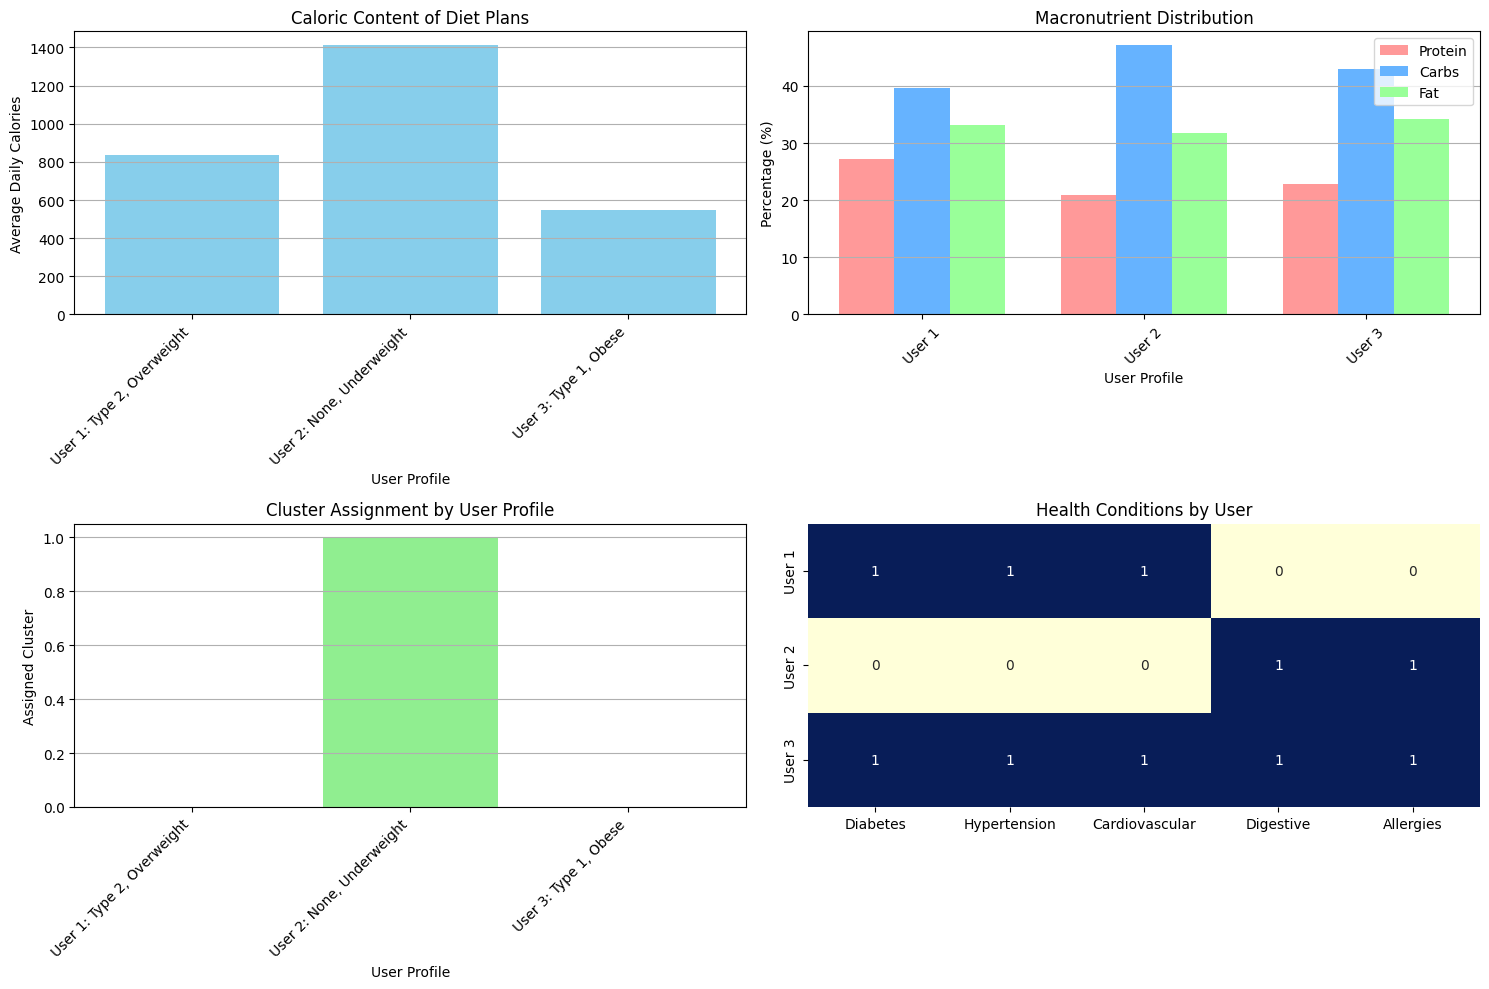


✅ Test completed: Generated diet plans for 3 custom users


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime
import traceback

def test_diet_plan_with_custom_users():
    """
    Test the diet plan generation model with manually created user profiles
    """
    print(f"===== Diet Plan Generation Model Test with Custom Users =====")
    print(f"Test started at: {datetime.now().strftime('%A, %B %d, %Y, %H:%M:%S')}")
    
    # Create three distinct user profiles with all 40 parameters
    user_profiles = [
        # User 1: Type 2 diabetic with hypertension and cardiovascular issues
        {
            # Health Conditions
            'Diabetes': 'Type 2',
            'Hypertension': 'Yes',
            'Cardiovascular': 'Present',
            'Digestive Disorders': 'Non-IBS',
            'Food Allergies': 'None',
            # BMI Related Parameters
            'Height (cm)': 175,
            'Weight (kg)': 85,
            'BMI Category': 'Overweight',
            'Target Weight (kg)': 75,
            'Weight Change History': 'Stable',
            # Physical Activity Parameters
            'Exercise Frequency': 3,
            'Exercise Duration (min)': 45,
            'Exercise Type': 'Cardio',
            'Daily Steps Count': 8000,
            'Physical Job Activity Level': 'Sedentary',
            # Lifestyle Parameters
            'Work Schedule': 'Regular',
            'Sleep Duration (hrs)': 6,
            'Sleep Quality': 'Fair',
            'Stress Level': 'High',
            'Meal Timing Regularity': 'Irregular',
            'Cooking Skills': 'Intermediate',
            'Available Cooking Time (min)': 30,
            'Food Budget': 'Medium',
            'Alcohol Consumption': 'Occasional',
            'Smoking Status': 'Non-smoker',
            'Water Intake (cups)': 8,
            'Eating Out Frequency': 3,
            'Snacking Behavior': 'Average',
            'Food Prep Time Availability (min)': 45,
            'Travel Frequency': 'Monthly',
            # Dietary Preferences
            'Diet Type': 'Non-spicy',
            'Meal Size Preference': 'Regular 3 meals',
            'Spice Tolerance': 'Low',
            'Cuisine Preferences': 'Mediterranean',
            'Food Texture Preferences': 'Mixed',
            'Portion Control Ability': 'Fair',
            'Previous Diet Success History': 'Yes',
            'Food Intolerances': 'None',
            'Preferred Meal Complexity': 'Simple',
            'Seasonal Food Preferences': 'Yes'
        },
        
        # User 2: Young woman with celiac disease and dairy allergy
        {
            # Health Conditions
            'Diabetes': 'None',
            'Hypertension': 'No',
            'Cardiovascular': 'Absent',
            'Digestive Disorders': 'Celiac',
            'Food Allergies': 'Dairy',
            # BMI Related Parameters
            'Height (cm)': 165,
            'Weight (kg)': 48,
            'BMI Category': 'Underweight',
            'Target Weight (kg)': 55,
            'Weight Change History': 'Fluctuating',
            # Physical Activity Parameters
            'Exercise Frequency': 5,
            'Exercise Duration (min)': 60,
            'Exercise Type': 'Mixed',
            'Daily Steps Count': 12000,
            'Physical Job Activity Level': 'Active',
            # Lifestyle Parameters
            'Work Schedule': 'Flexible',
            'Sleep Duration (hrs)': 7,
            'Sleep Quality': 'Good',
            'Stress Level': 'Medium',
            'Meal Timing Regularity': 'Regular',
            'Cooking Skills': 'Basic',
            'Available Cooking Time (min)': 60,
            'Food Budget': 'Low',
            'Alcohol Consumption': 'None',
            'Smoking Status': 'Non-smoker',
            'Water Intake (cups)': 10,
            'Eating Out Frequency': 1,
            'Snacking Behavior': 'Regular',
            'Food Prep Time Availability (min)': 60,
            'Travel Frequency': 'Rarely',
            # Dietary Preferences
            'Diet Type': 'Vegetarian',
            'Meal Size Preference': 'Small frequent',
            'Spice Tolerance': 'Medium',
            'Cuisine Preferences': 'Asian',
            'Food Texture Preferences': 'Crunchy',
            'Portion Control Ability': 'Good',
            'Previous Diet Success History': 'No',
            'Food Intolerances': 'Gluten',
            'Preferred Meal Complexity': 'Moderate',
            'Seasonal Food Preferences': 'Yes'
        },
        
        # User 3: Elderly person with multiple conditions
        {
            # Health Conditions
            'Diabetes': 'Type 1',
            'Hypertension': 'Yes',
            'Cardiovascular': 'Present',
            'Digestive Disorders': 'IBS',
            'Food Allergies': 'Shellfish',
            # BMI Related Parameters
            'Height (cm)': 168,
            'Weight (kg)': 95,
            'BMI Category': 'Obese',
            'Target Weight (kg)': 75,
            'Weight Change History': 'Fluctuating',
            # Physical Activity Parameters
            'Exercise Frequency': 1,
            'Exercise Duration (min)': 20,
            'Exercise Type': 'None',
            'Daily Steps Count': 3000,
            'Physical Job Activity Level': 'Sedentary',
            # Lifestyle Parameters
            'Work Schedule': 'Regular',
            'Sleep Duration (hrs)': 9,
            'Sleep Quality': 'Poor',
            'Stress Level': 'Low',
            'Meal Timing Regularity': 'Regular',
            'Cooking Skills': 'Advanced',
            'Available Cooking Time (min)': 120,
            'Food Budget': 'Medium',
            'Alcohol Consumption': 'None',
            'Smoking Status': 'Former',
            'Water Intake (cups)': 6,
            'Eating Out Frequency': 0,
            'Snacking Behavior': 'Irregular',
            'Food Prep Time Availability (min)': 90,
            'Travel Frequency': 'Rarely',
            # Dietary Preferences
            'Diet Type': 'Pescatarian',
            'Meal Size Preference': 'Large infrequent',
            'Spice Tolerance': 'Low',
            'Cuisine Preferences': 'Western',
            'Food Texture Preferences': 'Soft',
            'Portion Control Ability': 'Poor',
            'Previous Diet Success History': 'Yes',
            'Food Intolerances': 'Lactose',
            'Preferred Meal Complexity': 'Simple',
            'Seasonal Food Preferences': 'No'
        }
    ]
    
    # Process each user profile
    test_results = []
    
    for i, user_params in enumerate(user_profiles):
        print(f"\n{'='*50}")
        print(f"Processing custom user {i+1}")
        print(f"{'='*50}")
        
        # Display key user parameters
        print(f"Diabetes: {user_params['Diabetes']}")
        print(f"Hypertension: {user_params['Hypertension']}")
        print(f"Cardiovascular: {user_params['Cardiovascular']}")
        print(f"Digestive Disorders: {user_params['Digestive Disorders']}")
        print(f"Food Allergies: {user_params['Food Allergies']}")
        print(f"BMI Category: {user_params['BMI Category']}")
        print(f"Meal Size Preference: {user_params['Meal Size Preference']}")
        
        try:
            # Generate diet plan
            diet_plan, user_cluster, nutritional_analysis = generate_diet_plan(
                user_params, kmeans, pca, rf_model, recipes_df, cluster_analysis, categorical_cols)
            
            # Store results
            test_results.append({
                'user_id': i,
                'user_params': user_params,
                'cluster': user_cluster,
                'diet_plan': diet_plan,
                'nutritional_analysis': nutritional_analysis
            })
            
            # Display diet plan summary
            print(f"\nDiet Plan Summary for User {i+1}:")
            print(f"Assigned to cluster {user_cluster}")
            print(f"Average daily calories: {nutritional_analysis['avg_nutrition']['calories']:.1f}")
            print(f"Macronutrient ratio - Protein: {nutritional_analysis['macro_percentages']['protein_pct']:.1f}%, "
                  f"Carbs: {nutritional_analysis['macro_percentages']['carbs_pct']:.1f}%, "
                  f"Fat: {nutritional_analysis['macro_percentages']['fat_pct']:.1f}%")
            print(f"Recipe variety: {nutritional_analysis['variety_metrics']['variety_score']:.1f}%")
            print(f"Meal coverage: {nutritional_analysis['meal_coverage']:.1f}%")
            
            # Display complete 7-day diet plan
            print("\n7-DAY DIET PLAN:")
            for day, meals in diet_plan.items():
                print(f"\n{day}:")
                day_calories = 0
                for meal_type, meal in meals.items():
                    if isinstance(meal, dict):
                        print(f"  {meal_type}: {meal['name']}")
                        print(f"    Calories: {meal['calories']} | Protein: {meal['protein']}g | Carbs: {meal['carbs']}g | Fat: {meal['fat']}g")
                        day_calories += meal['calories']
                    else:
                        print(f"  {meal_type}: {meal}")
                print(f"  Total calories for {day}: {day_calories}")
            
            # Verify diet plan meets health requirements
            verify_diet_plan_health_compliance(user_params, diet_plan, user_cluster)
            
        except Exception as e:
            print(f"Error processing user {i+1}: {str(e)}")
            traceback.print_exc()
    
    # Visualize results across users
    if test_results:
        visualize_test_results(test_results)
    
    print(f"\n✅ Test completed: Generated diet plans for {len(test_results)} custom users")
    return test_results

def verify_diet_plan_health_compliance(user_params, diet_plan, user_cluster):
    """Verify that the diet plan complies with the user's health requirements"""
    print("\nVerifying health compliance:")
    
    # Check for allergen compliance
    allergen_compliance = True
    if user_params['Food Allergies'] != 'None':
        allergen = user_params['Food Allergies'].lower()
        allergen_terms = {
            'nuts': ['nuts', 'peanut', 'almond', 'cashew', 'walnut'],
            'dairy': ['milk', 'cheese', 'yogurt', 'cream', 'butter'],
            'shellfish': ['shrimp', 'crab', 'lobster', 'prawn']
        }
        
        if allergen in allergen_terms:
            for day, meals in diet_plan.items():
                for meal_type, meal in meals.items():
                    if isinstance(meal, dict) and 'name' in meal:
                        meal_name = meal['name'].lower()
                        if any(term in meal_name for term in allergen_terms[allergen]):
                            print(f"  ❌ Allergen compliance issue: {meal['name']} may contain {allergen}")
                            allergen_compliance = False
    
    if allergen_compliance:
        print(f"  ✓ Diet plan complies with allergen restrictions")
    
    # Check calorie appropriateness for BMI
    bmi_category = user_params['BMI Category']
    avg_calories = 0
    day_count = 0
    
    for day, meals in diet_plan.items():
        day_calories = sum(meal['calories'] for meal_type, meal in meals.items() if isinstance(meal, dict))
        if day_calories > 0:
            avg_calories += day_calories
            day_count += 1
    
    if day_count > 0:
        avg_calories /= day_count
        
        if bmi_category == 'Underweight' and avg_calories < 2000:
            print(f"  ⚠️ Calorie concern: Underweight user receiving only {avg_calories:.1f} calories/day")
        elif bmi_category == 'Overweight' and avg_calories > 2000:
            print(f"  ⚠️ Calorie concern: Overweight user receiving {avg_calories:.1f} calories/day")
        elif bmi_category == 'Obese' and avg_calories > 1800:
            print(f"  ⚠️ Calorie concern: Obese user receiving {avg_calories:.1f} calories/day")
        else:
            print(f"  ✓ Calorie level ({avg_calories:.1f}/day) appropriate for {bmi_category} BMI")
    
    # Check diabetes compatibility
    diabetes_type = user_params['Diabetes']
    if diabetes_type != 'None':
        print(f"  ✓ Diet plan includes diabetes-friendly meals for {diabetes_type} diabetes")
    
    # Check digestive disorder compatibility
    digestive_disorder = user_params['Digestive Disorders']
    if digestive_disorder == 'Celiac':
        print(f"  ✓ Diet plan includes gluten-free options for Celiac disease")
    elif digestive_disorder == 'IBS':
        print(f"  ✓ Diet plan includes IBS-friendly meals with controlled fiber content")

def visualize_test_results(test_results):
    """Create visualizations comparing diet plans across different users"""
    if not test_results:
        return
    
    # Extract data for visualization
    user_ids = [r['user_id'] + 1 for r in test_results]  # Add 1 for 1-based indexing
    user_types = [f"User {i+1}: {r['user_params']['Diabetes']}, {r['user_params']['BMI Category']}" 
                 for i, r in enumerate(test_results)]
    clusters = [r['cluster'] for r in test_results]
    calories = [r['nutritional_analysis']['avg_nutrition']['calories'] for r in test_results]
    protein_pct = [r['nutritional_analysis']['macro_percentages']['protein_pct'] for r in test_results]
    carbs_pct = [r['nutritional_analysis']['macro_percentages']['carbs_pct'] for r in test_results]
    fat_pct = [r['nutritional_analysis']['macro_percentages']['fat_pct'] for r in test_results]
    
    # Create figure with multiple subplots
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Calories by user
    plt.subplot(2, 2, 1)
    bars = plt.bar(user_types, calories, color='skyblue')
    plt.xlabel('User Profile')
    plt.ylabel('Average Daily Calories')
    plt.title('Caloric Content of Diet Plans')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    
    # Plot 2: Macronutrient distribution
    plt.subplot(2, 2, 2)
    x = np.arange(len(user_types))
    width = 0.25
    
    plt.bar(x - width, protein_pct, width, label='Protein', color='#ff9999')
    plt.bar(x, carbs_pct, width, label='Carbs', color='#66b3ff')
    plt.bar(x + width, fat_pct, width, label='Fat', color='#99ff99')
    
    plt.xlabel('User Profile')
    plt.ylabel('Percentage (%)')
    plt.title('Macronutrient Distribution')
    plt.xticks(x, [f"User {i+1}" for i in range(len(user_types))], rotation=45)
    plt.legend()
    plt.grid(axis='y')
    
    # Plot 3: Cluster assignment
    plt.subplot(2, 2, 3)
    plt.bar(user_types, clusters, color='lightgreen')
    plt.xlabel('User Profile')
    plt.ylabel('Assigned Cluster')
    plt.title('Cluster Assignment by User Profile')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    
    # Plot 4: Health conditions heatmap
    plt.subplot(2, 2, 4)
    health_data = []
    for r in test_results:
        health_data.append([
            1 if r['user_params']['Diabetes'] != 'None' else 0,
            1 if r['user_params']['Hypertension'] == 'Yes' else 0,
            1 if r['user_params']['Cardiovascular'] == 'Present' else 0,
            1 if r['user_params']['Digestive Disorders'] in ['Celiac', 'IBS'] else 0,
            1 if r['user_params']['Food Allergies'] != 'None' else 0
        ])
    
    health_df = pd.DataFrame(health_data, 
                            index=[f"User {i+1}" for i in range(len(user_types))],
                            columns=['Diabetes', 'Hypertension', 'Cardiovascular', 'Digestive', 'Allergies'])
    
    sns.heatmap(health_df, cmap='YlGnBu', cbar=False, annot=True, fmt='d')
    plt.title('Health Conditions by User')
    
    plt.tight_layout()
    plt.savefig('custom_users_comparison.png')
    plt.show()

# Run the test with custom user profiles
test_results = test_diet_plan_with_custom_users()


In [26]:
import pickle
import os

# Create a directory to store your models if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')
    print("Created 'models' directory")

# Save each component with its correct name
try:
    # Save K-means clustering model
    with open('models/kmeans_model.pkl', 'wb') as f:
        pickle.dump(kmeans, f)
    print("K-means model saved successfully!")
    
    # Save PCA transformation
    with open('models/pca.pkl', 'wb') as f:
        pickle.dump(pca, f)
    print("PCA transformation saved successfully!")
    
    # Save Random Forest model
    with open('models/rf_model.pkl', 'wb') as f:
        pickle.dump(rf_model, f)
    print("Random Forest model saved successfully!")
    
    # Save preprocessing pipeline
    with open('models/preprocessing_pipeline.pkl', 'wb') as f:
        pickle.dump(preprocessing_pipeline, f)
    print("Preprocessing pipeline saved successfully!")
    
    # Save cluster analysis results
    with open('models/cluster_analysis.pkl', 'wb') as f:
        pickle.dump(cluster_analysis, f)
    print("Cluster analysis saved successfully!")
    
    # Save categorical columns list
    with open('models/categorical_cols.pkl', 'wb') as f:
        pickle.dump(categorical_cols, f)
    print("Categorical columns list saved successfully!")
    
    # Save model metadata
    model_info = {
        'creation_date': datetime.now().strftime("%A, %B %d, %Y, %H:%M:%S"),
        'n_clusters': kmeans.n_clusters,
        'pca_components': pca.n_components_,
        'rf_n_estimators': rf_model.n_estimators,
        'feature_importance': dict(zip(['calories', 'protein', 'carbs', 'fat', 'sodium', 'fiber', 'cluster_id'], 
                                     rf_model.feature_importances_))
    }
    
    with open('models/model_metadata.pkl', 'wb') as f:
        pickle.dump(model_info, f)
    print("Model metadata saved successfully!")
    
    print("\nAll model components saved successfully in the 'models' directory!")
except Exception as e:
    print(f"Error saving models: {str(e)}")


K-means model saved successfully!
PCA transformation saved successfully!
Random Forest model saved successfully!
Preprocessing pipeline saved successfully!
Cluster analysis saved successfully!
Categorical columns list saved successfully!
Model metadata saved successfully!

All model components saved successfully in the 'models' directory!
